# Necessary libraries

In [1]:
#!pip install statsforecast

In [2]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

/home/jupyter-apaddo/.local/lib/python3.9/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from scipy.interpolate import CubicSpline, InterpolatedUnivariateSpline, Akima1DInterpolator
from datetime import datetime, timedelta
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
#from datetime import timedelta
#import datetime
#import fbprophet
#from matplotlib import pyplot
from pandas import to_datetime
from statsmodels.tsa.arima_model import ARIMA
#from fbprophet import Prophet
#from pmdarima.arima import auto_arima
#import pmdarima
from scipy import interpolate
#from fbprophet import Prophet
from matplotlib import pyplot
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import plotly.graph_objs as go
import sklearn.model_selection
from scipy import stats
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from scipy.interpolate import CubicSpline as CS
from statistics import mean
import math
from pmdarima.arima import auto_arima

2023-09-04 16:22:18.000473: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-04 16:22:18.021953: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-04 16:22:18.022235: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 16:22:18.514299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
df_for=pd.read_csv("6_df_interpolated_for_forecasting_aug10.csv")
#df_for=df_for.drop(["Unnamed: 0"],axis=1)
df_for

Unnamed: 0        Date    Area Gender   Race    Ethinicity  Wound
0                 0  2016-10-26  4.0000      M  White  Non-Hispanic      1
1                 1  2016-10-27  4.0000      M  White  Non-Hispanic      1
2                 2  2016-10-28  4.0000      M  White  Non-Hispanic      1
3                 3  2016-10-29  4.0000      M  White  Non-Hispanic      1
4                 4  2016-10-30  4.0000      M  White  Non-Hispanic      1
...             ...         ...     ...    ...    ...           ...    ...
1290115     1290115  2023-01-05  2.7064      F  White  Non-Hispanic  17884
1290116     1290116  2023-01-06  2.7064      F  White  Non-Hispanic  17884
1290117     1290117  2023-01-07  2.7064      F  White  Non-Hispanic  17884
1290118     1290118  2023-01-08  2.7064      F  White  Non-Hispanic  17884
1290119     1290119  2023-01-09  2.7064      F  White  Non-Hispanic  17884

[1290120 rows x 7 columns]

In [5]:
def make_input_for_arima(df):    
    #display(df)
    df = df.rename(columns={'Date': 'ds', 'Area': 'y'})
    df['unique_id']='unique_wound'
    df=df.reset_index()
    df=df.drop(['index'],axis=1)
    #display(df)
    total_n=df.shape[0]
    n=math.ceil(0.15*total_n)
    dff=pd.concat([df, df.tail(n), df.tail(n),df.head(2),df.head(2)]).drop_duplicates(keep=False)
    #display(test)
    #display(dff)
    sample_row=dff.sample(1)
    a=int(sample_row.index.values)
    b=int(sample_row.index.values)+n
    print(a)
    print(b)
    test=df[a:b]
    train=pd.concat([df, test, test]).drop_duplicates(keep=False)
    #display(train)
    return (test,train,df)

In [6]:
# def make_input_for_arima(df):    
#     #display(df)
#     df = df.rename(columns={'Date': 'ds', 'Area': 'y'})
#     df['unique_id']='unique_wound'
#     df=df.reset_index()
#     df=df.drop(['index'],axis=1)
#     #display(df)
#     total_n=df.shape[0]
#     n=math.ceil(0.15*total_n)
#     dff=pd.concat([df, df.tail(n), df.tail(n)]).drop_duplicates(keep=False)
#     #display(test)
#     #display(dff)
#     sample_row=dff.sample(1)
#     a=int(sample_row.index.values)
#     b=int(sample_row.index.values)+n
#     print(a)
#     print(b)
#     test=df[a:b]
#     train=pd.concat([df, test, test]).drop_duplicates(keep=False)
#     #display(train)
#     return (test,train,df)

In [12]:
def model_arima(test, train, df):

    # Assuming you have your DataFrame 'df' containing 'ds', 'y', and other columns
    # Sort the DataFrame by date
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds')

    # Initialize the AutoARIMA model
    arima_model = StatsForecast(
        models=[AutoARIMA(season_length=7)],  # You can adjust the season_length as needed
        freq='d'
    )

    # Initialize an empty DataFrame to store predictions
    predictions = []

    # Iterate over specific past dates for which you want predictions
    #specific_dates = ['2019-03-11', '2019-03-12', '2019-03-13']  # Replace with your desired dates
    specific_dates=test['ds'].values
    for date in specific_dates:
        # Filter data up to the specific date
        train_data = df[df['ds'] <= date]
        #train_data=train

        # Fit the model using the filtered data
        arima_model.fit(train_data)

        # Predict using the model for the specific date
        forecast_df = arima_model.predict(1)  # Predict one step (one day)

        # Extract the predicted y value for the specific date
        predicted_y = forecast_df['AutoARIMA'].values[0]

        # Append the prediction to the predictions DataFrame
        predictions.append({'ds': date, 'predicted_y': predicted_y})

    # Print the predictions
    #print(predictions)

    y_hat_avg = test.copy()
    y_hat_avg['ARIMA']=pd.DataFrame(predictions)['predicted_y'].values

#     print(y_hat_avg['ARIMA'])
    plt.figure(figsize=(16,8))
    #plt.plot( train['y'], label='Train')
    #plt.plot(test['y'], label='Test')
    plt.plot(df['y'],label='Original')
    plt.plot(y_hat_avg['ARIMA'], label='Forecasted by AutoARIMA')
    plt.legend(loc='best')
    #plt.axhline(0)
    plt.grid()
    plt.xlabel('Days')
    plt.ylabel('Wound Area')
    plt.show()




    #Accuracy measure of the model (to be done next)
    forecast=y_hat_avg.ARIMA
    actual=test.y
    training_series=train.y
    testing_series=test.y
    prediction_series= y_hat_avg.ARIMA



    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
     #as R-square value does not for forecasted value and actual value because forecasted values are 14 more than actual values, thus I am taking only the forecasted values minusing the last 14 values of the forecasted dataframe.
    # df = df.iloc[:-2]
    forecast_without_last14=forecast.iloc[:-14]
    actual_without_nan=actual.dropna()
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    #corr= np.corrcoef(forecast_without_last14,actual_without_nan)[0,1]
    r_square= corr**2
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]  # ACF1

    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    errors = np.abs(testing_series - prediction_series )
    mase=errors.mean()/d

#     #print("For Subject ID:", list[i])
#     print("MASE:",mase)
#     #print("MAPE:",mape)
#     #print("ME:",me)
#     #print("MAE:",mae)
#     #print("MPE:",mpe)
#     print("RMSE:",rmse)
#     #print("CORR:",corr)
#     print("R-SQUARE",r_square)
#     #print("MINMAX:",minmax)
    return (rmse, mase, r_square)

In [13]:
# def model_arima(test, train):
    
#     arima_model = StatsForecast(
#         models = [AutoARIMA(season_length = 12)],
#         freq = 'M'
#     )
# #     if train.Area.shape[0]>3:
# #         arima_model =auto_arima(train.Area,start_p=2, d=1, start_q=1,max_p=4, max_d=5, max_q=4, start_P=2,
# #                             D=0, start_Q=4, max_P=2, max_D=5,max_Q=4, m=12, seasonal=True,
# #                             error_action='warn', trace = True, supress_warnings=True, stepwise = True, 
# #                             random_state=20,n_fits = 50 )
# #     if train.Area.shape[0]<=3:
# #         arima_model =auto_arima(train.Area,start_p=2, d=1, start_q=1,max_p=4, max_d=5, max_q=4, start_P=2,
# #                             D=1, start_Q=4, max_P=2, max_D=5,max_Q=4, m=12, seasonal=False,
# #                             error_action='warn', trace = True, supress_warnings=True, stepwise = True, 
# #                             random_state=20,n_fits = 50 )
# #     arima_model =auto_arima(train.Area,start_p=2, d=1, start_q=4,max_p=2, max_d=5, max_q=4, start_P=2,
# #                             D=1, start_Q=4, max_P=2, max_D=5,max_Q=4, m=12, seasonal=False,
# #                             error_action='warn', trace = True, supress_warnings=True, stepwise = True, 
# #                             random_state=20,n_fits = 50 )
# #     if train.Area.shape[0]<8 or train.Area.shape[0]==9:
# #         fit1 = sm.tsa.statespace.SARIMAX(train.Area, order=(2, 0, 4),seasonal_order=(0,1,1,7),initialization='approximate_diffuse').fit(disp=0)
# #     else:
# #         fit1 = sm.tsa.statespace.SARIMAX(train.Area, order=(2, 1, 4),seasonal_order=(0,1,1,7),initialization='approximate_diffuse').fit(disp=0)

#     y_hat_avg = test.copy()
#     y_hat_avg['ARIMA']=arima_model.predict(len(test)).values

# #   y_hat_avg['ARIMA'] = fit1.forecast(len(test))
# #     print(y_hat_avg['ARIMA'])
#     plt.figure(figsize=(16,8))
#     plt.plot( train['Area'], label='Train')
#     plt.plot(test['Area'], label='Test')
#     plt.plot(y_hat_avg['ARIMA'], label='ARIMA')
#     plt.legend(loc='best')
#     #plt.axhline(0)
#     plt.grid()
#     plt.xlabel('Date')
#     plt.ylabel('Wound Area')
#     plt.show()




#     #Accuracy measure of the model (to be done next)
#     forecast=y_hat_avg.ARIMA
#     actual=test.Area
#     training_series=train.Area
#     testing_series=test.Area
#     prediction_series= y_hat_avg.ARIMA



#     mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     me = np.mean(forecast - actual)             # ME
#     mae = np.mean(np.abs(forecast - actual))    # MAE
#     mpe = np.mean((forecast - actual)/actual)   # MPE
#     rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#      #as R-square value does not for forecasted value and actual value because forecasted values are 14 more than actual values, thus I am taking only the forecasted values minusing the last 14 values of the forecasted dataframe.
#     # df = df.iloc[:-2]
#     forecast_without_last14=forecast.iloc[:-14]
#     actual_without_nan=actual.dropna()
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     #corr= np.corrcoef(forecast_without_last14,actual_without_nan)[0,1]
#     r_square= corr**2
# #     mins = np.amin(np.hstack([forecast[:,None], 
# #                               actual[:,None]]), axis=1)
# #     maxs = np.amax(np.hstack([forecast[:,None], 
# #                               actual[:,None]]), axis=1)
# #     minmax = 1 - np.mean(mins/maxs)             # minmax
#     #acf1 = acf(fc-test)[1]  # ACF1

#     n = training_series.shape[0]
#     d = np.abs(  np.diff( training_series) ).sum()/(n-1)
#     errors = np.abs(testing_series - prediction_series )
#     mase=errors.mean()/d

# #     #print("For Subject ID:", list[i])
# #     print("MASE:",mase)
# #     #print("MAPE:",mape)
# #     #print("ME:",me)
# #     #print("MAE:",mae)
# #     #print("MPE:",mpe)
# #     print("RMSE:",rmse)
# #     #print("CORR:",corr)
# #     print("R-SQUARE",r_square)
# #     #print("MINMAX:",minmax)
#     return (rmse, mase, r_square)

 

# def model_holtwinters(test, train):
#     #fit1 = sm.tsa.statespace.SARIMAX(train.Area, order=(2, 1, 4),seasonal_order=(0,1,1,7),initialization='approximate_diffuse').fit()
#     fit1 = ExponentialSmoothing(np.asarray(train['Area']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()

#     y_hat_avg = test.copy()
#     y_hat_avg['ARIMA'] = fit1.forecast(len(test))
#     print(y_hat_avg['ARIMA'])
#     plt.figure(figsize=(16,8))
#     plt.plot( train['Area'], label='Train')
#     plt.plot(test['Area'], label='Test')
#     plt.plot(y_hat_avg['ARIMA'], label='ARIMA')
#     plt.legend(loc='best')
#     #plt.axhline(0)
#     plt.grid()
#     plt.xlabel('Date')
#     plt.ylabel('Wound Area')
#     plt.show()




#     #Accuracy measure of the model (to be done next)
#     forecast=y_hat_avg.ARIMA
#     actual=test.Area
#     training_series=train.Area
#     testing_series=test.Area
#     prediction_series= y_hat_avg.ARIMA



#     mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     me = np.mean(forecast - actual)             # ME
#     mae = np.mean(np.abs(forecast - actual))    # MAE
#     mpe = np.mean((forecast - actual)/actual)   # MPE
#     rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#      #as R-square value does not for forecasted value and actual value because forecasted values are 14 more than actual values, thus I am taking only the forecasted values minusing the last 14 values of the forecasted dataframe.
#     # df = df.iloc[:-2]
#     #forecast_without_last14=forecast.iloc[:-14]
#     #actual_without_nan=actual.dropna()
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     #corr= np.corrcoef(forecast_without_last14,actual_without_nan)[0,1]
#     r_square= corr**2
# #     mins = np.amin(np.hstack([forecast[:,None], 
# #                               actual[:,None]]), axis=1)
# #     maxs = np.amax(np.hstack([forecast[:,None], 
# #                               actual[:,None]]), axis=1)
# #     minmax = 1 - np.mean(mins/maxs)             # minmax
#     #acf1 = acf(fc-test)[1]  # ACF1

#     n = training_series.shape[0]
#     d = np.abs(  np.diff( training_series) ).sum()/(n-1)
#     errors = np.abs(testing_series - prediction_series )
#     mase=errors.mean()/d

#     #print("For Subject ID:", list[i])
#     print("MASE:",mase)
#     print("MAPE:",mape)
#     print("ME:",me)
#     print("MAE:",mae)
#     print("MPE:",mpe)
#     print("RMSE:",rmse)
#     print("CORR:",corr)
#     print("R-SQUARE",r_square)
#     print("MINMAX:",minmax)
#     return (rmse, mase, r_square)




## Counting the number of wounds from patients from different categories and running ARIMA model

Wound: 1
59
79


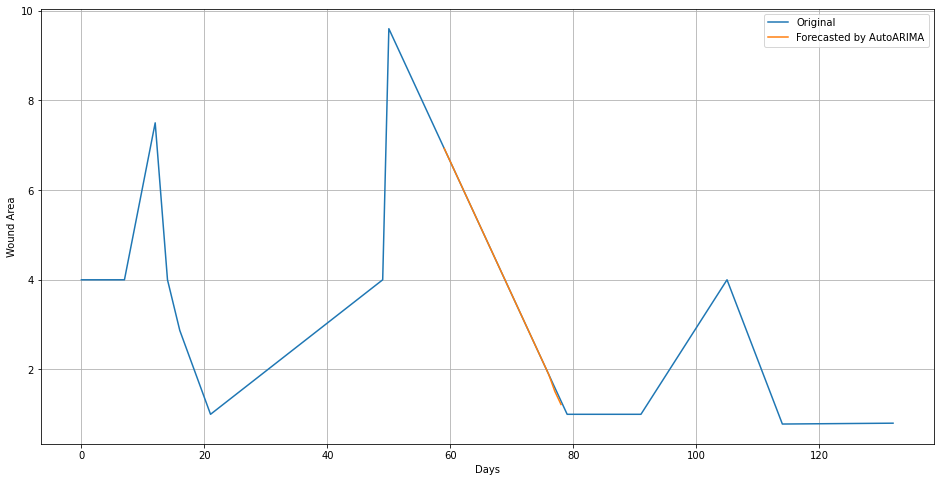

Wound: 2
19
32


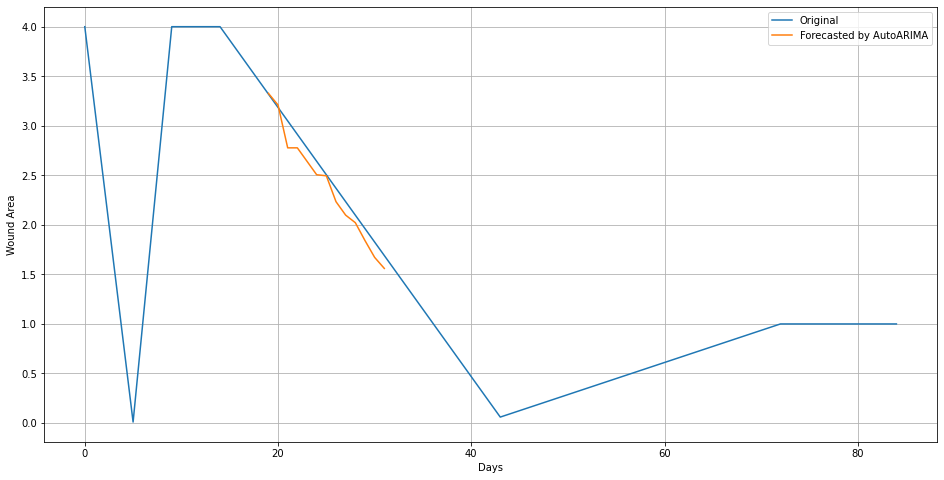

Wound: 3
6
8


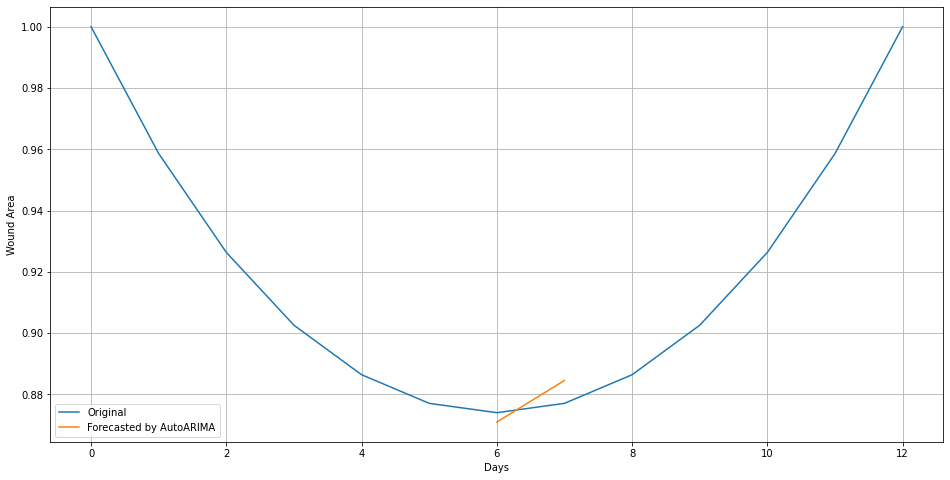

Wound: 4
2
5


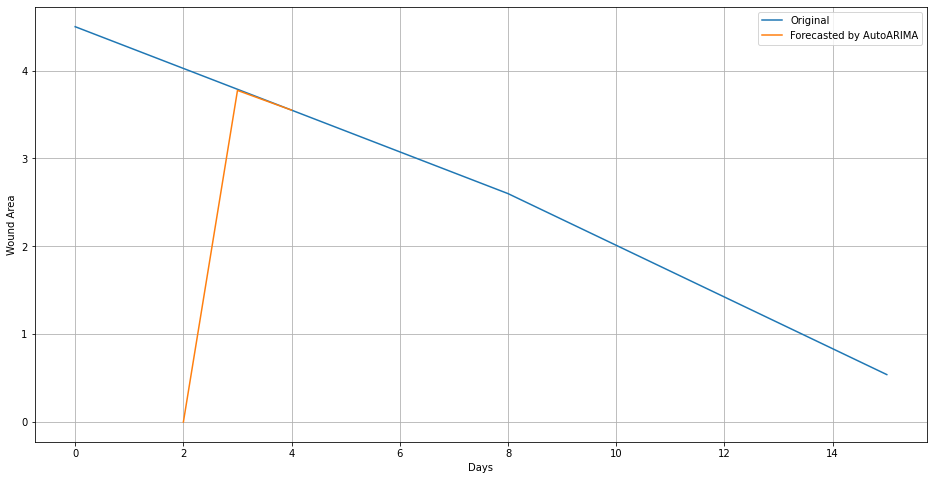

Wound: 5
6
9


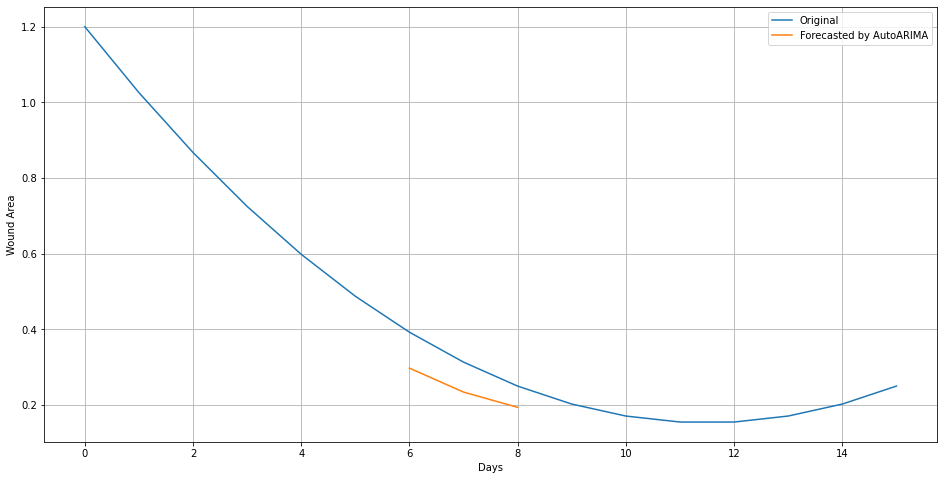

Wound: 6
252
304


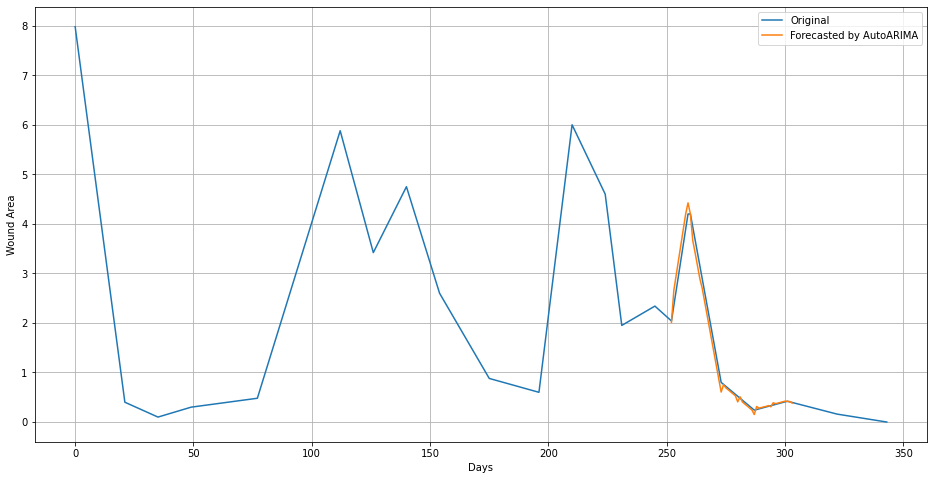

Wound: 7
4
7


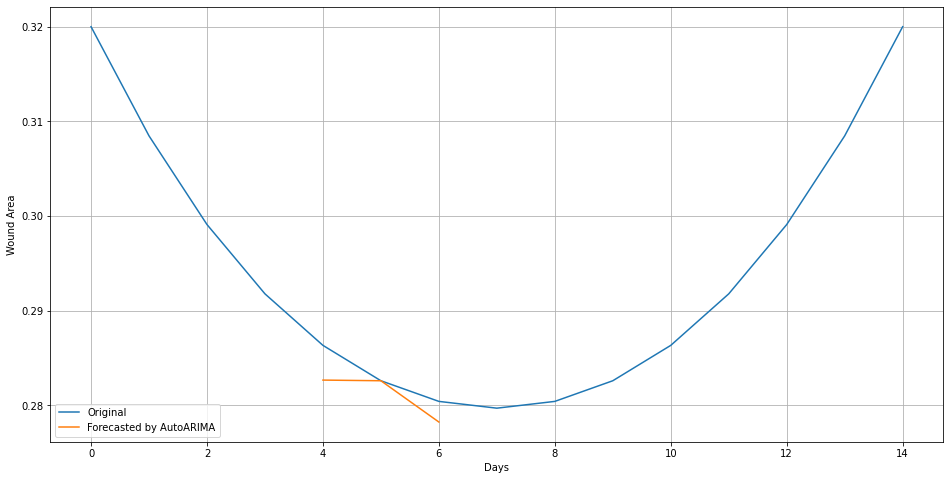

Wound: 8
18
24


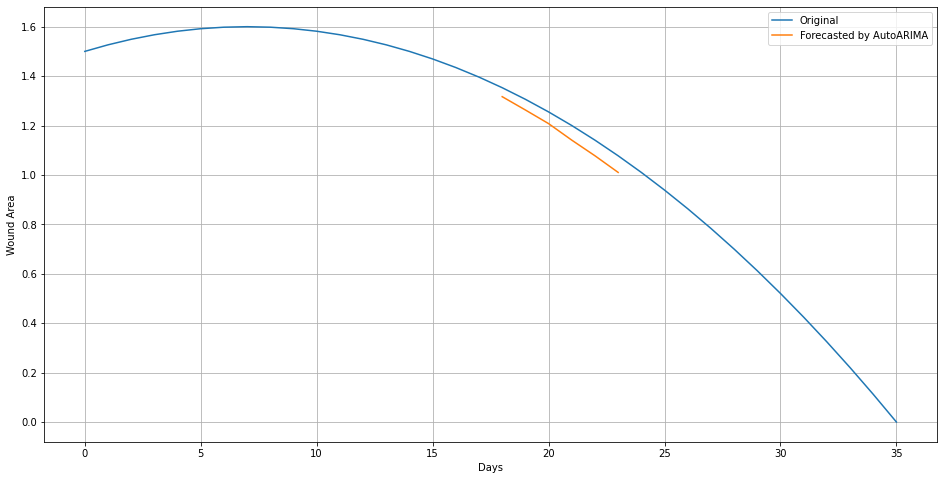

Wound: 9
70
108


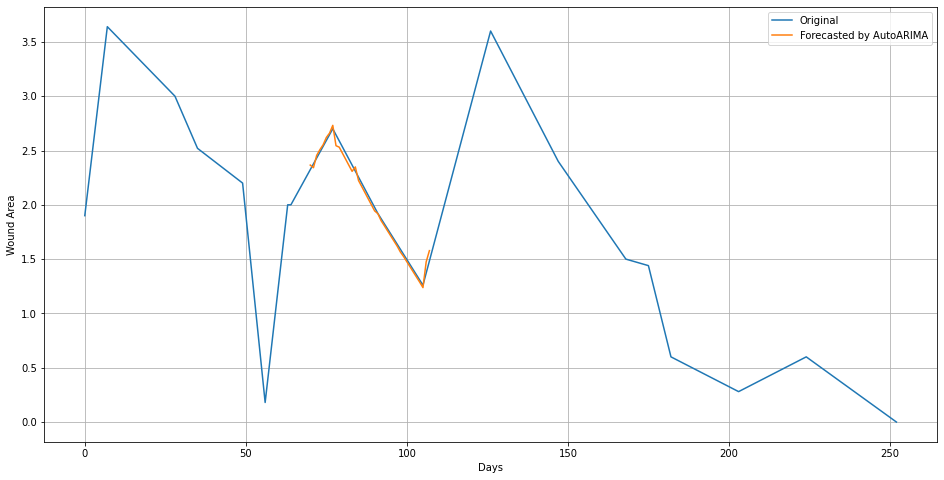

Wound: 10
101
124


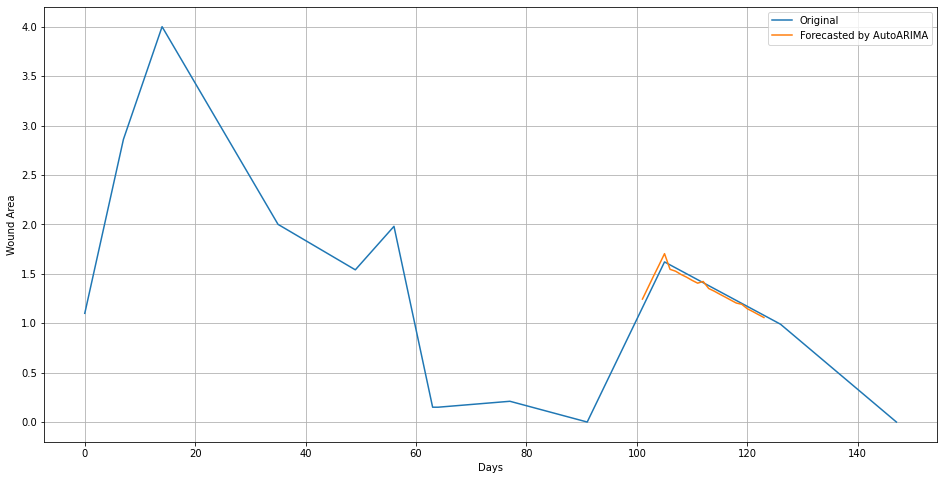

Wound: 11
32
39


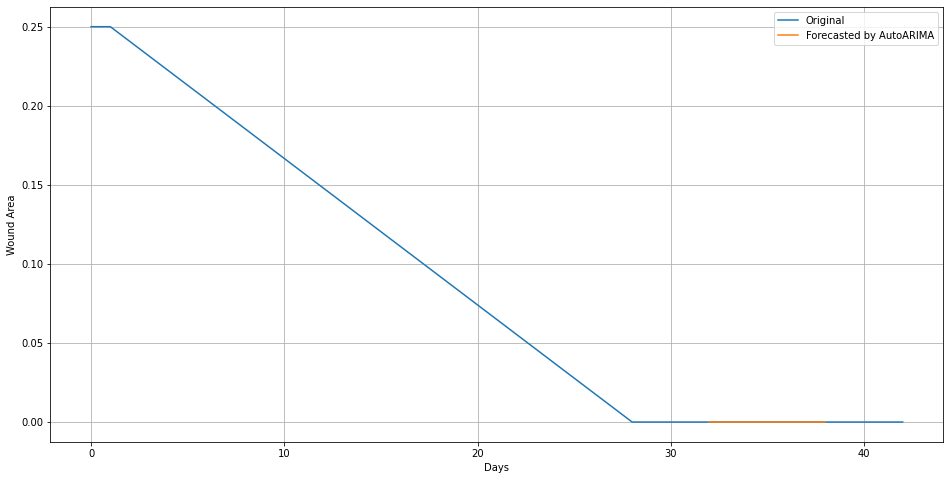

Wound: 12
6
9


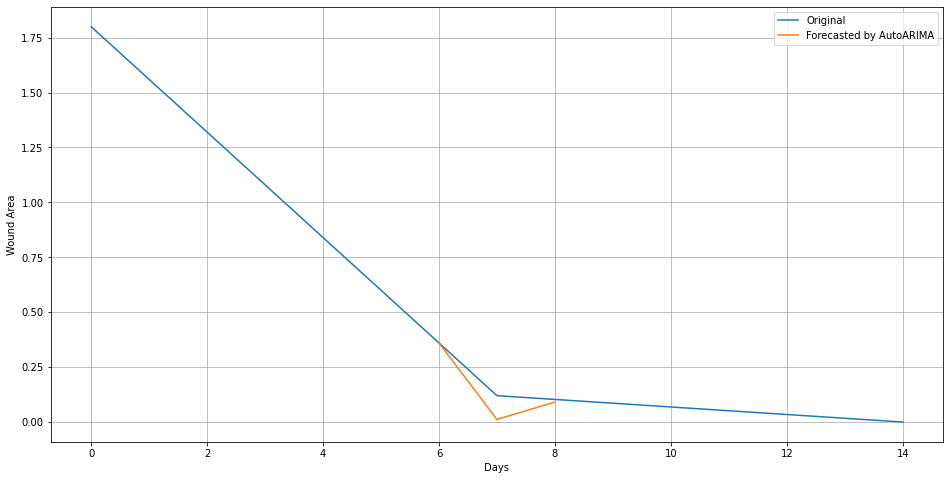

Wound: 13
341
421


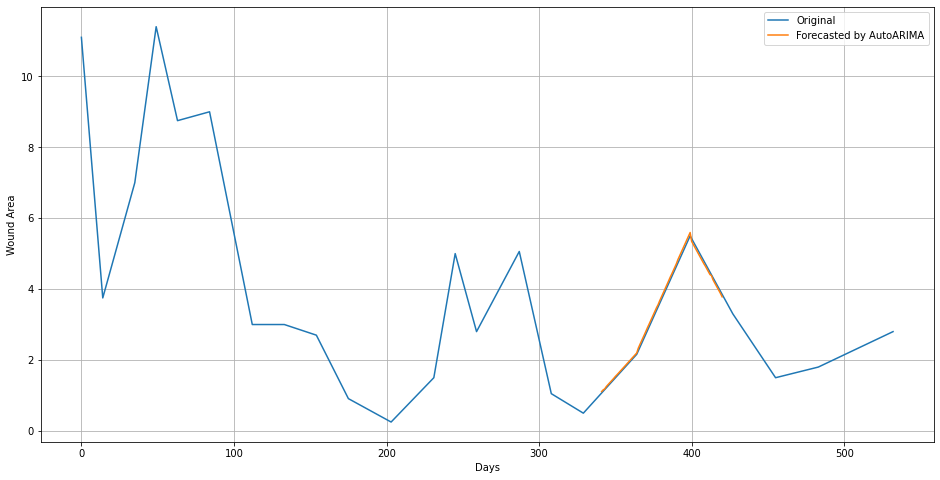

Wound: 14
19
32


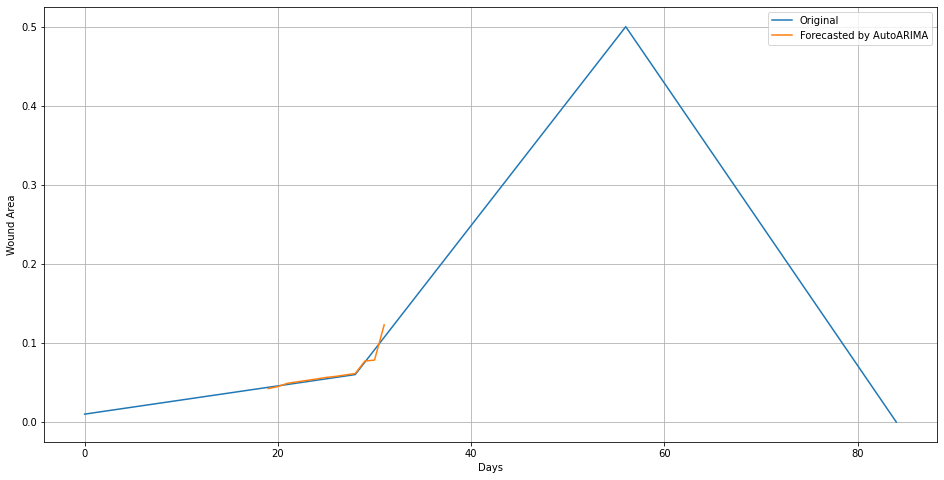

Wound: 15
70
110


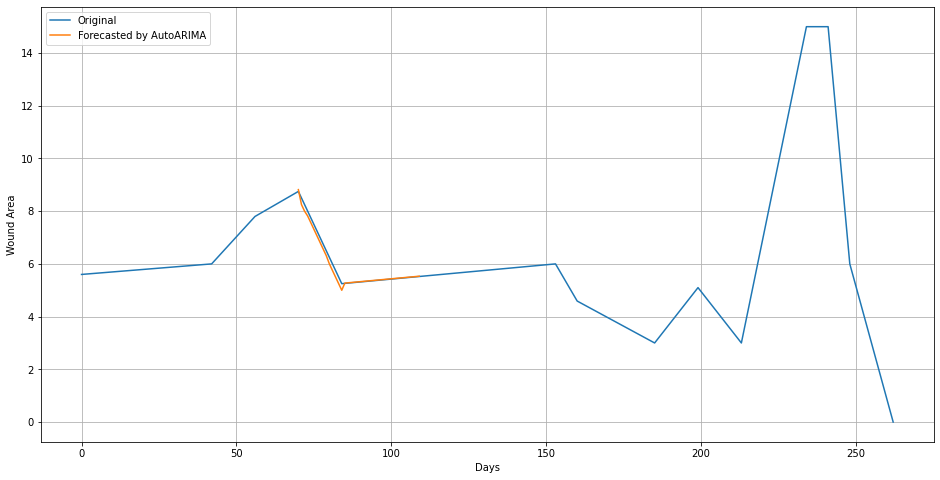

Wound: 16
10
16


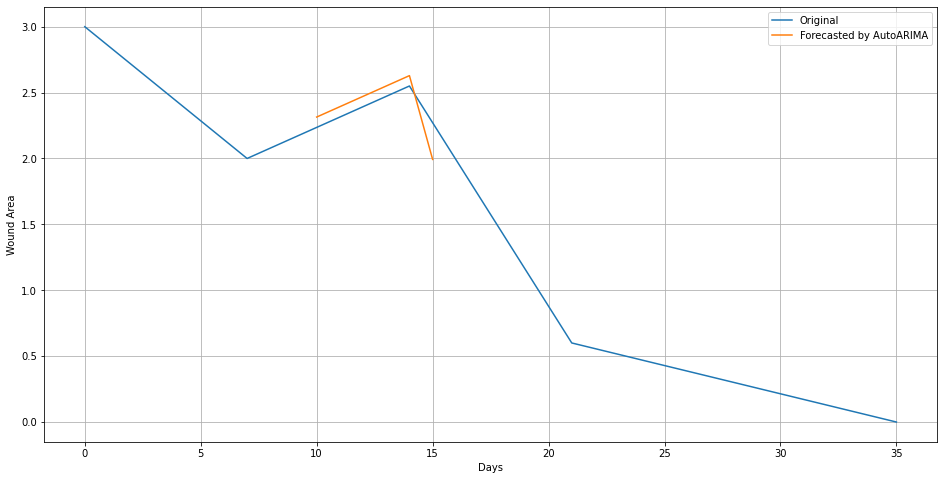

Wound: 17
4
16


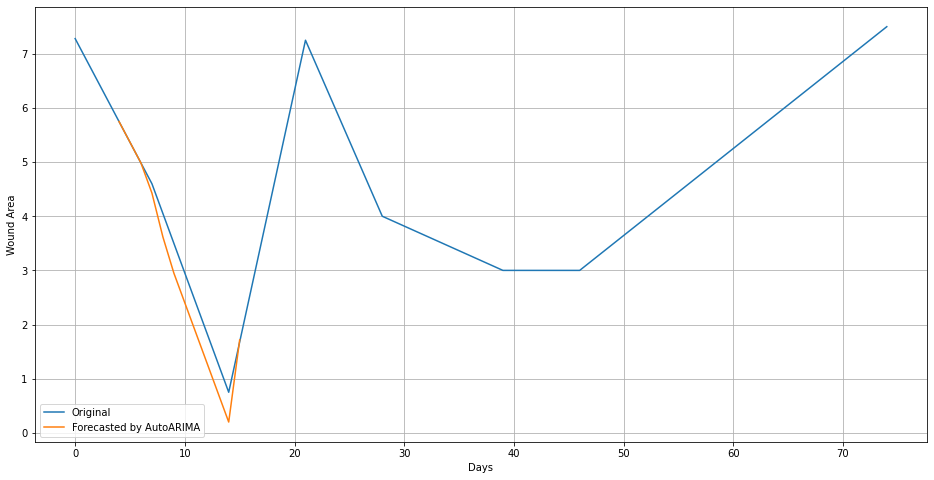

Wound: 18
11
14


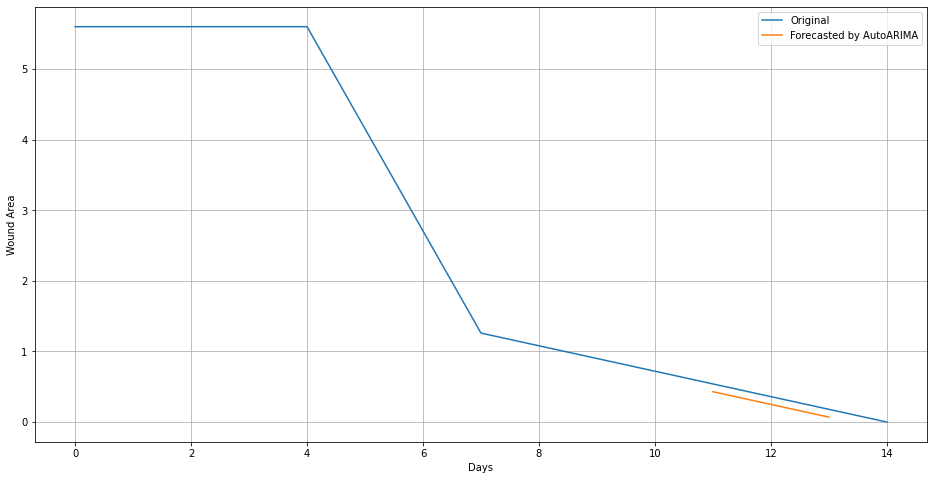

Wound: 19
7
16


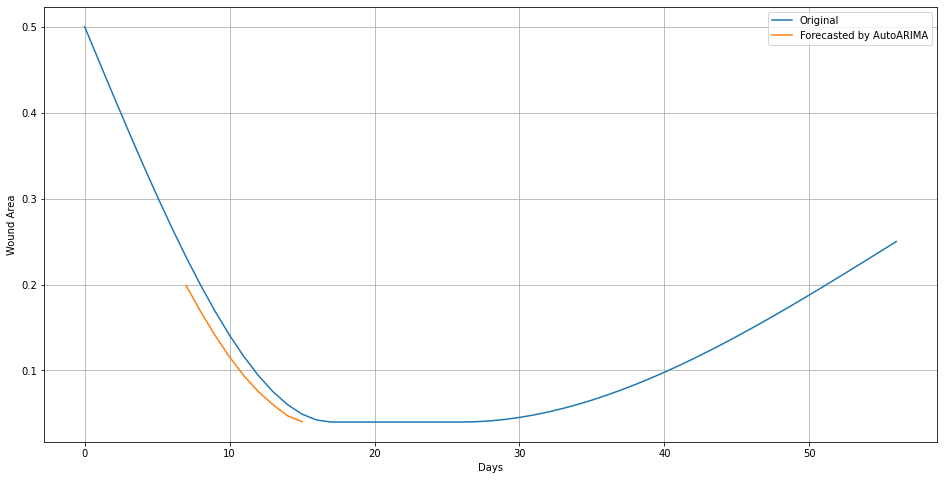

Wound: 20
183
231


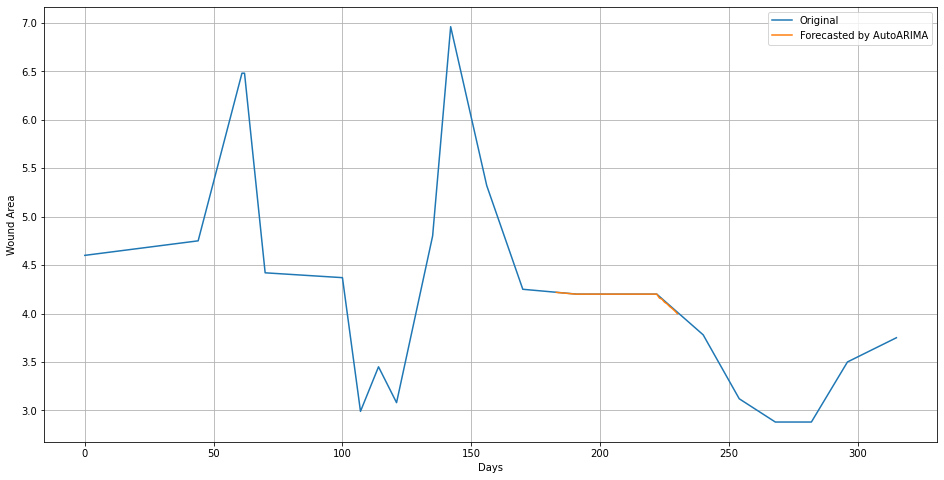

Wound: 21
8
26


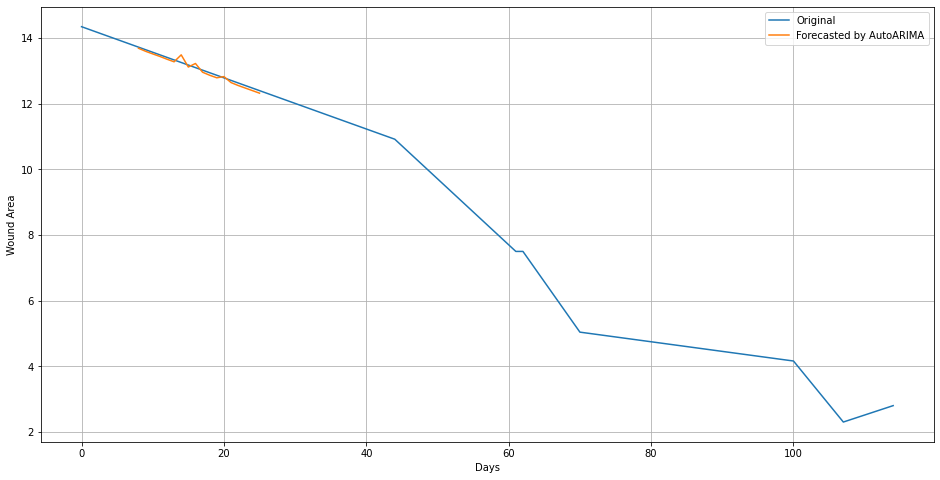

Wound: 22
33
42


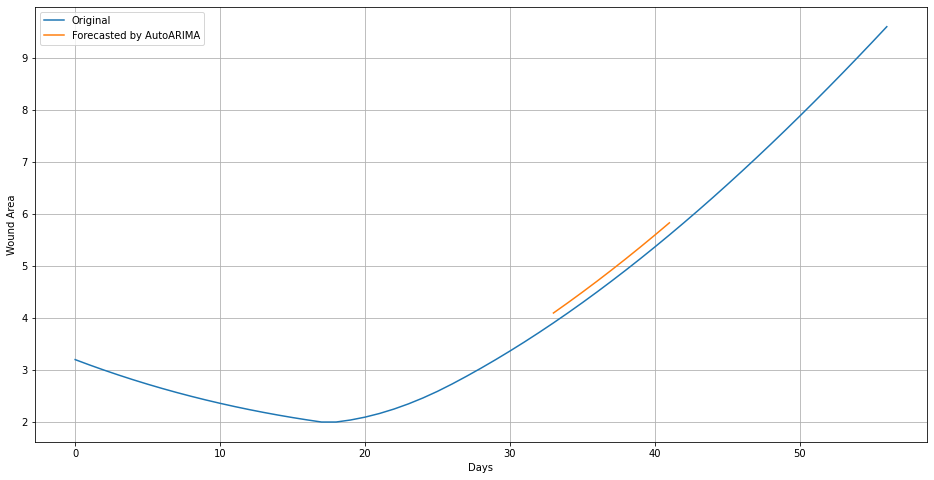

Wound: 23
8
17


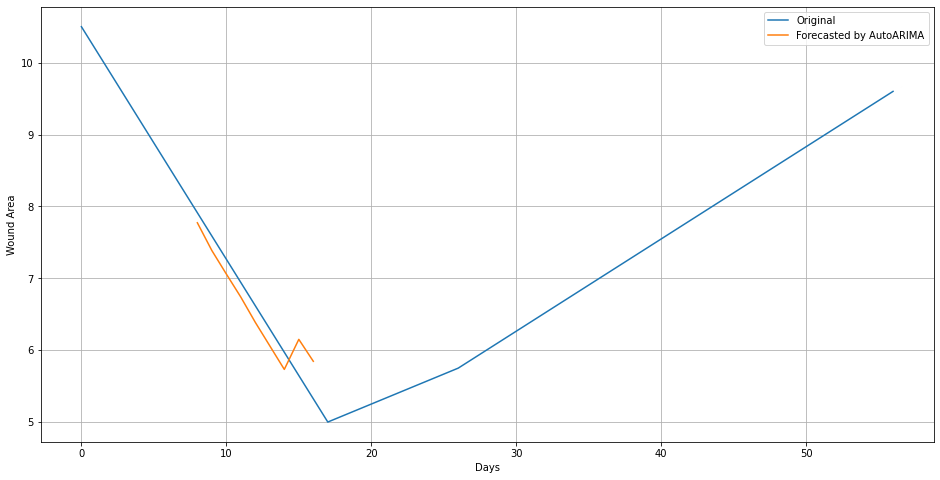

Wound: 24
18
40


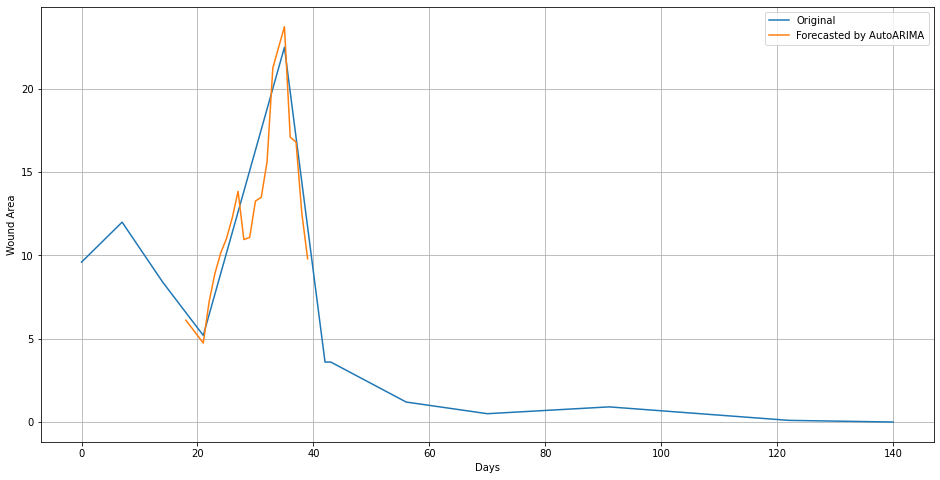

Wound: 25
71
99


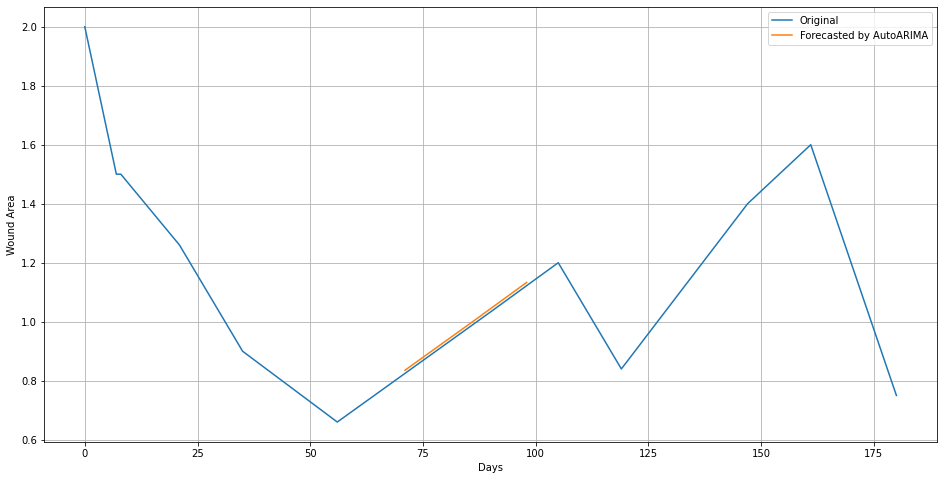

Wound: 26
168
240


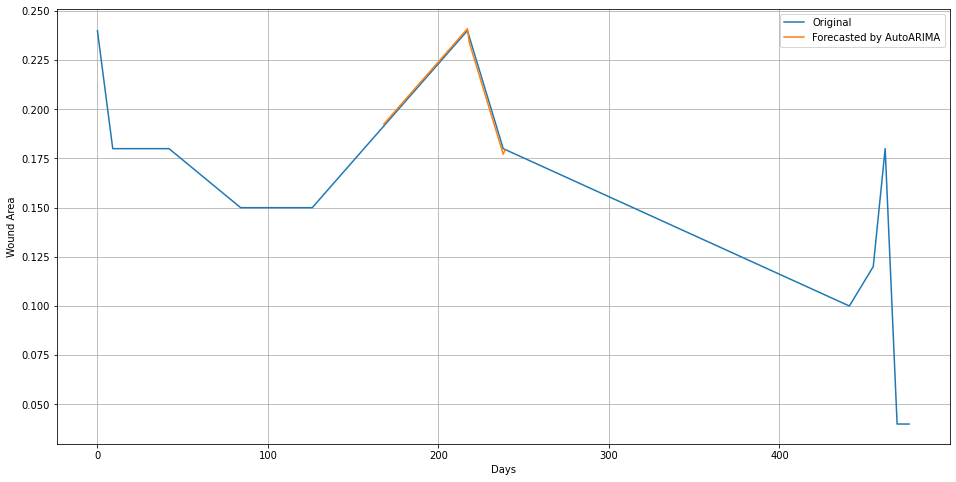

Wound: 27
115
143


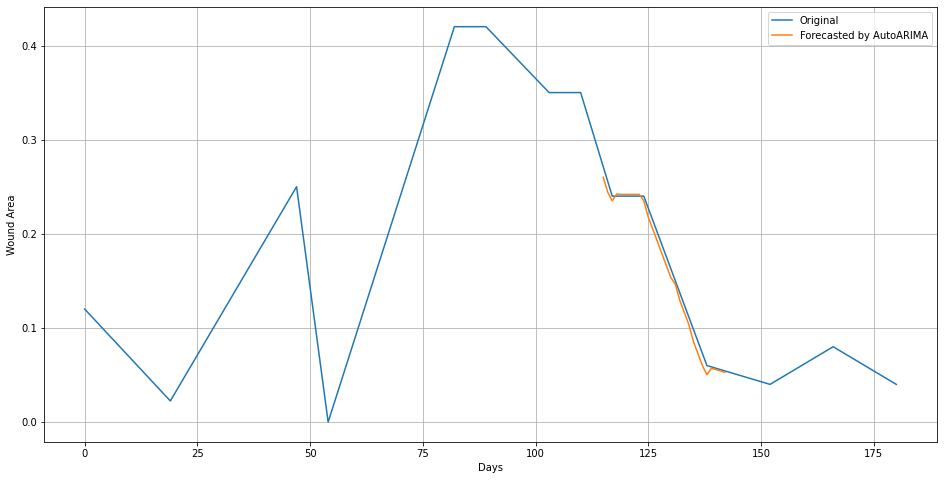

Wound: 28
12
25


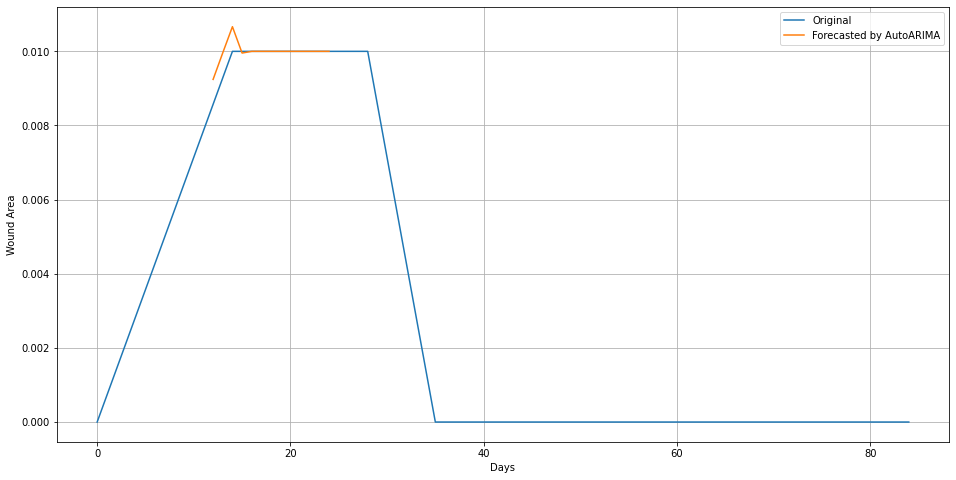

Wound: 29
23
30


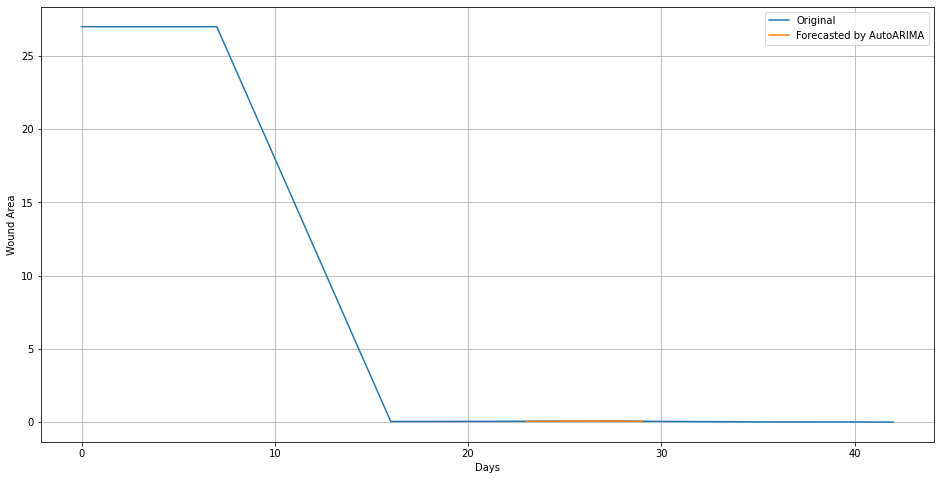

Wound: 30
7
18


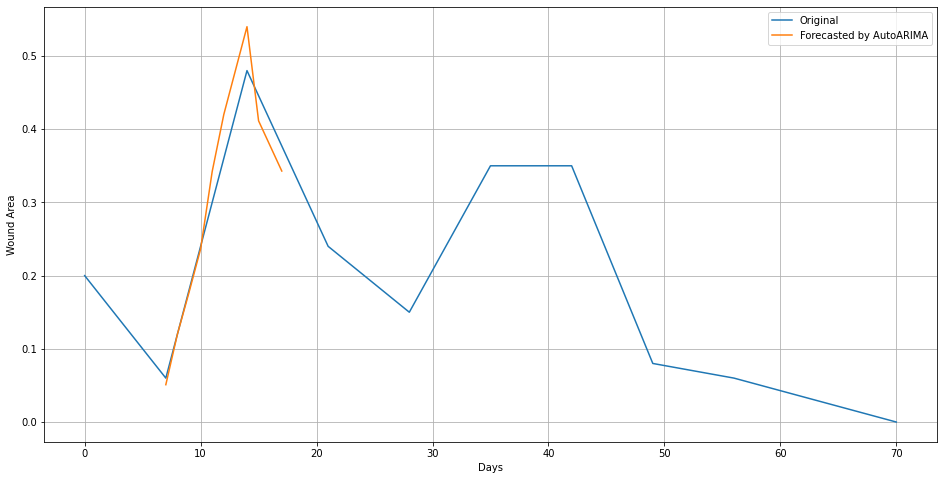

Wound: 31
6
10


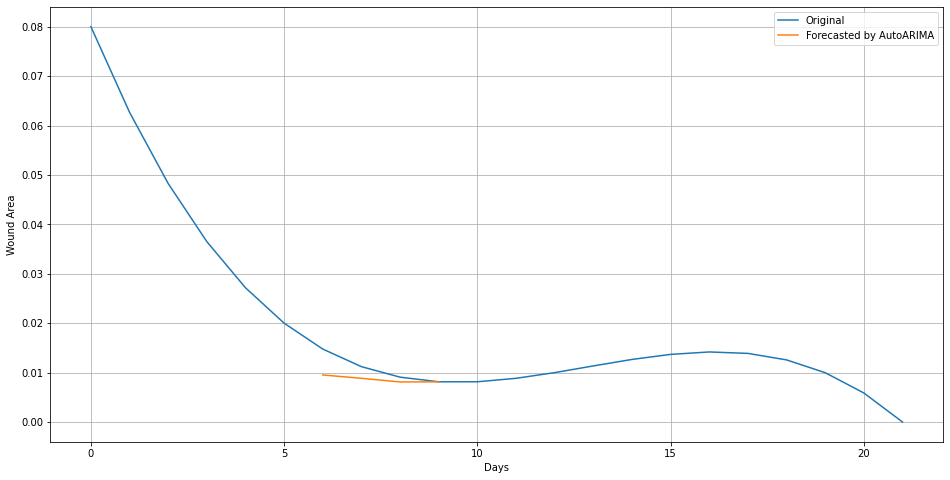

Wound: 32
75
99


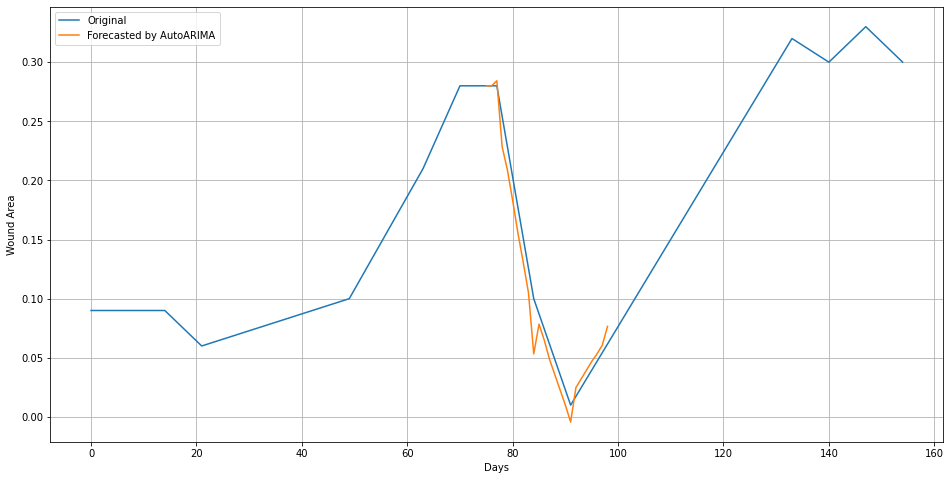

Wound: 33
17
21


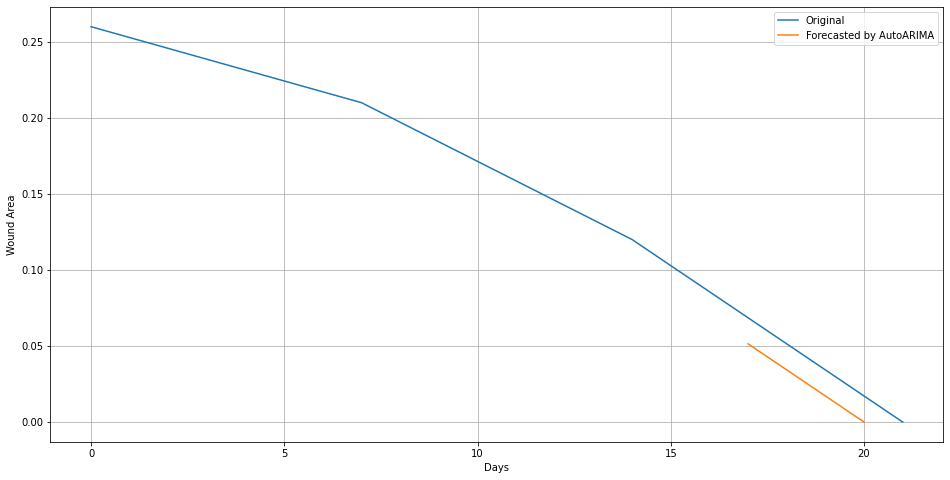

Wound: 34
141
215


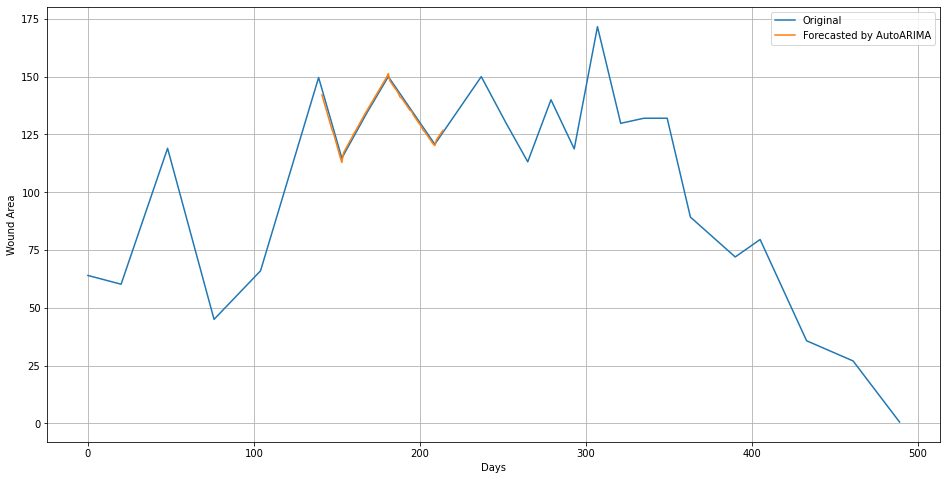

Wound: 35
45
62


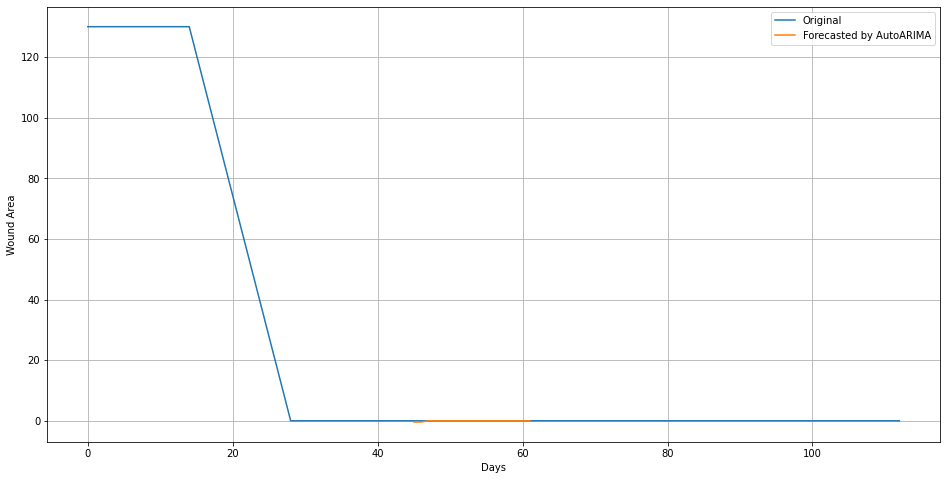

Wound: 36
15
20


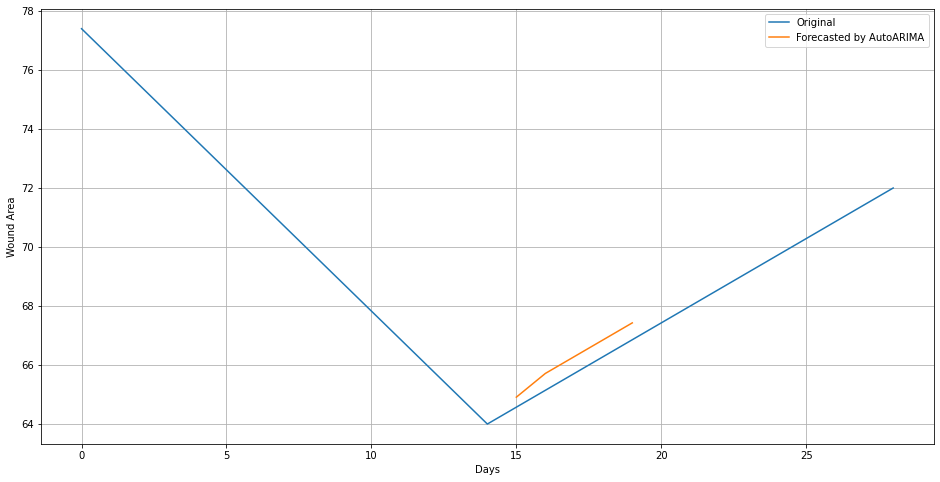

Wound: 37
113
138


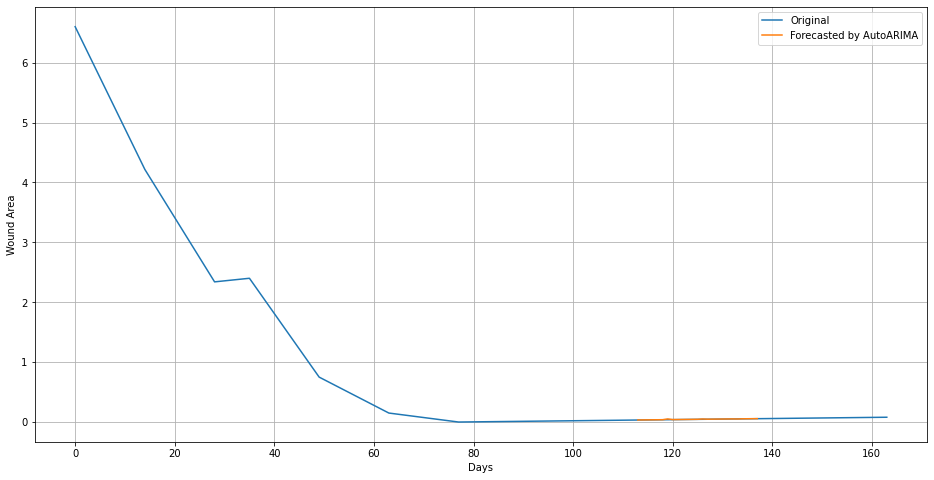

Wound: 38
37
55


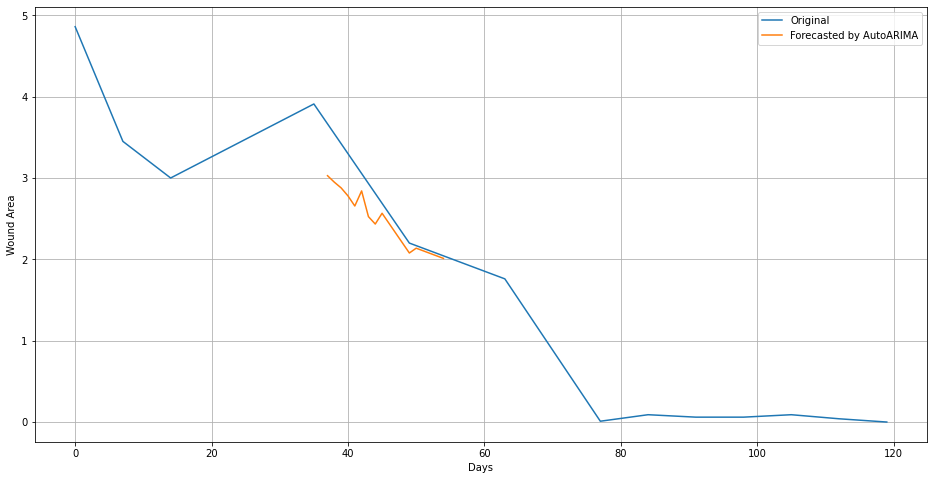

Wound: 39
71
94


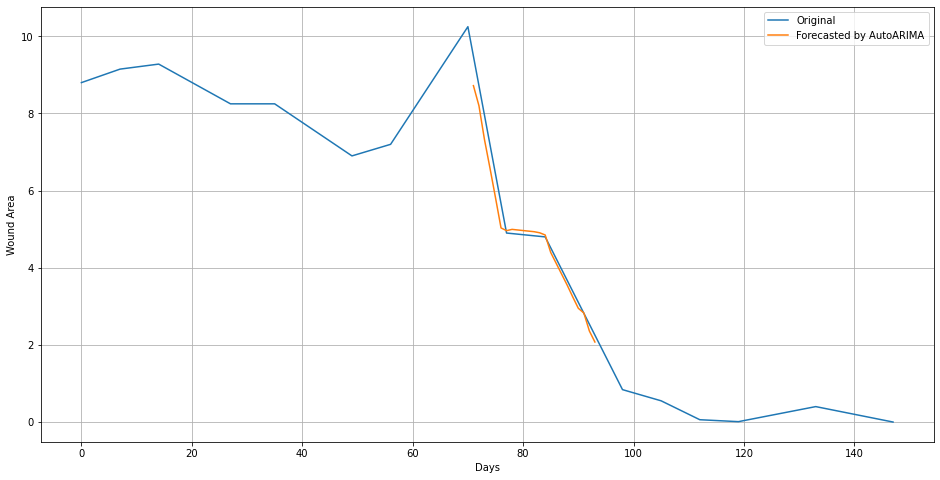

Wound: 40
5
12


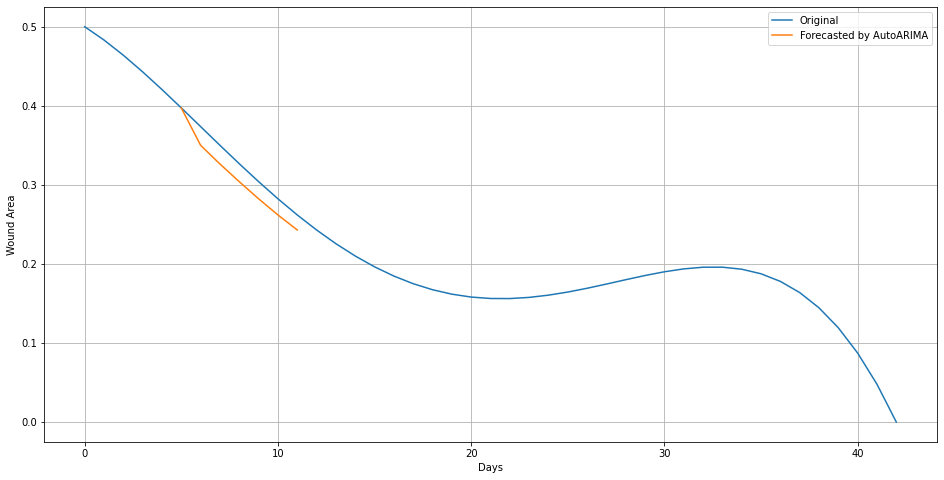

Wound: 41
6
9


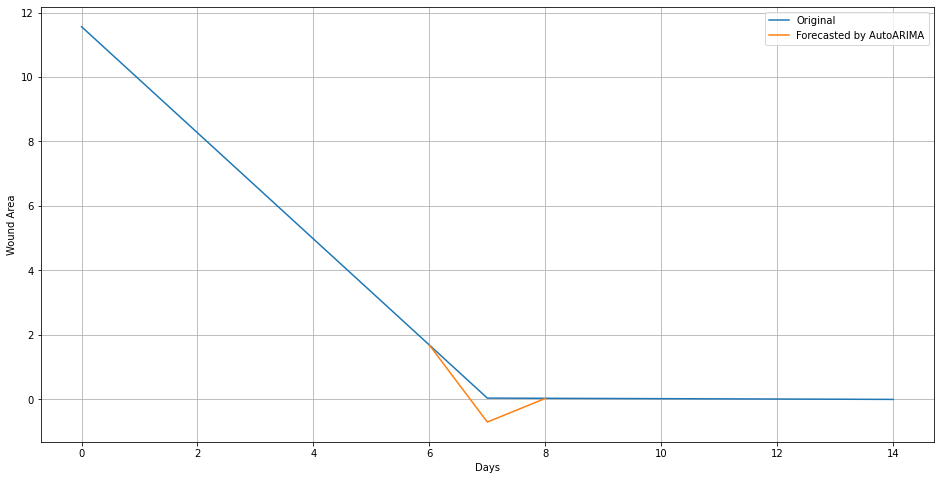

Wound: 42
36
44


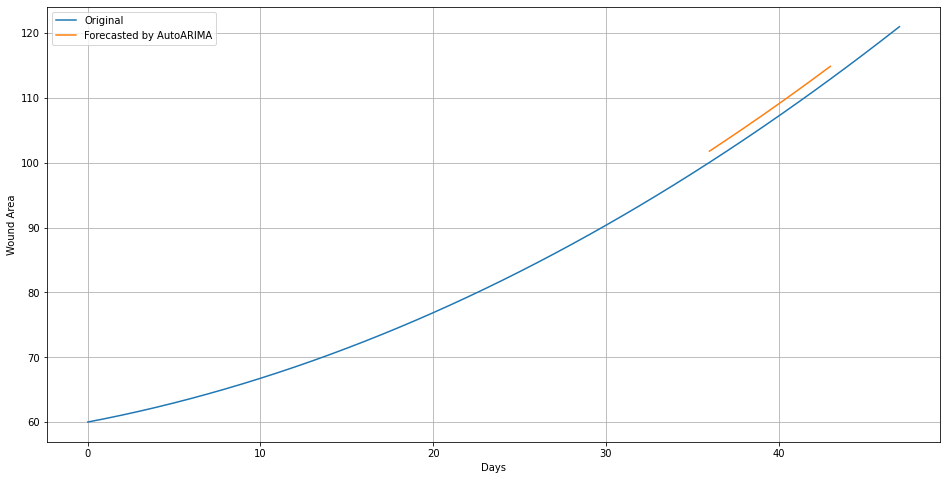

Wound: 43
10
19


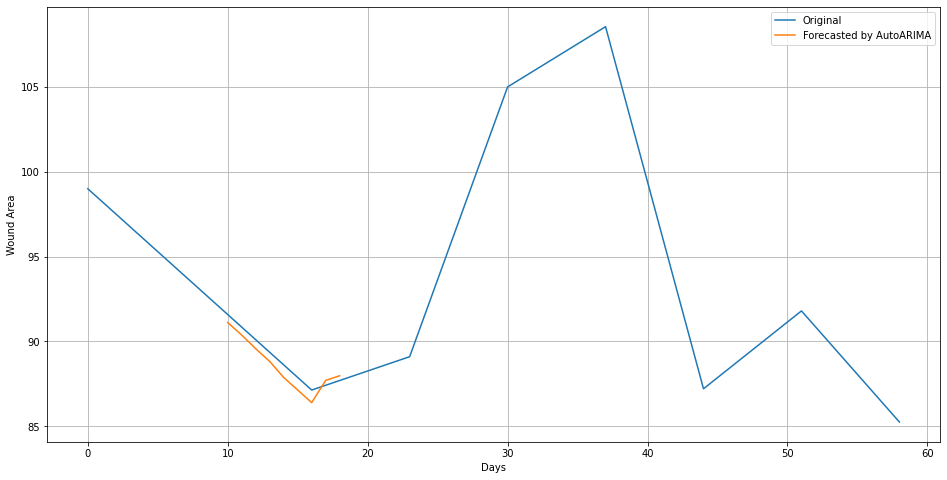

Wound: 44
16
26


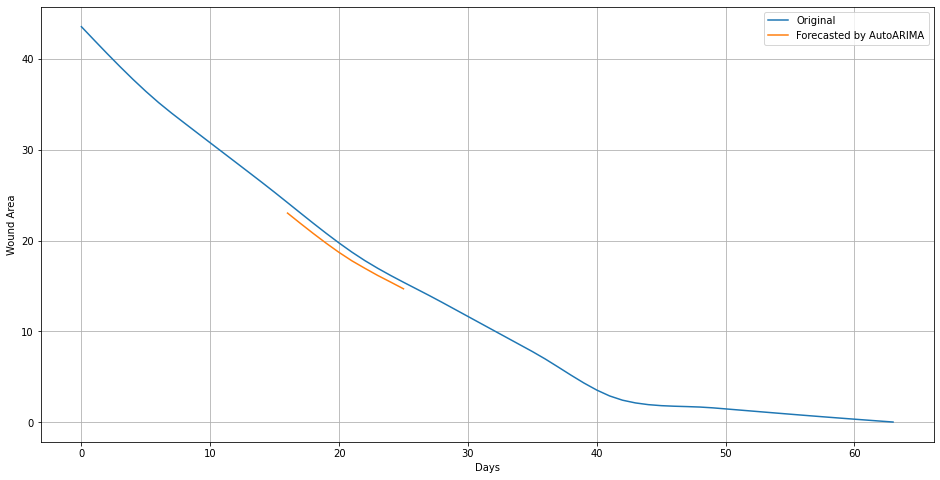

Wound: 45
23
29


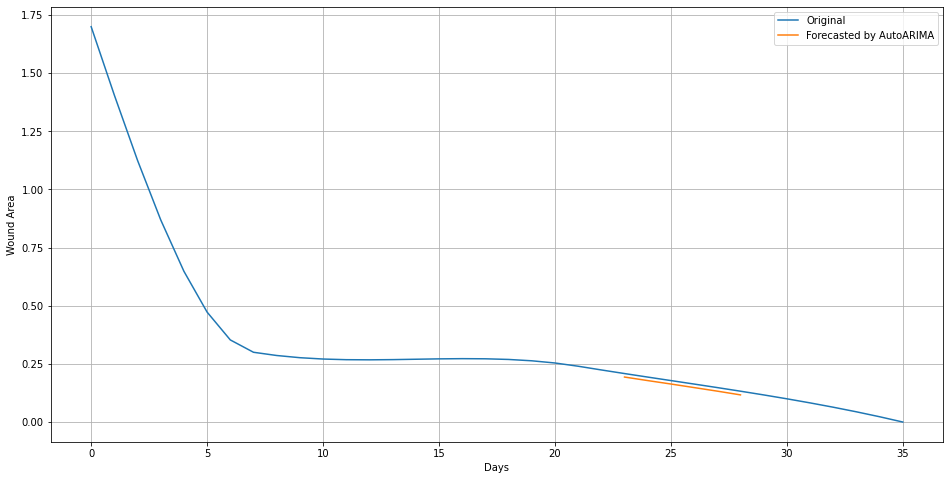

Wound: 46
14
22


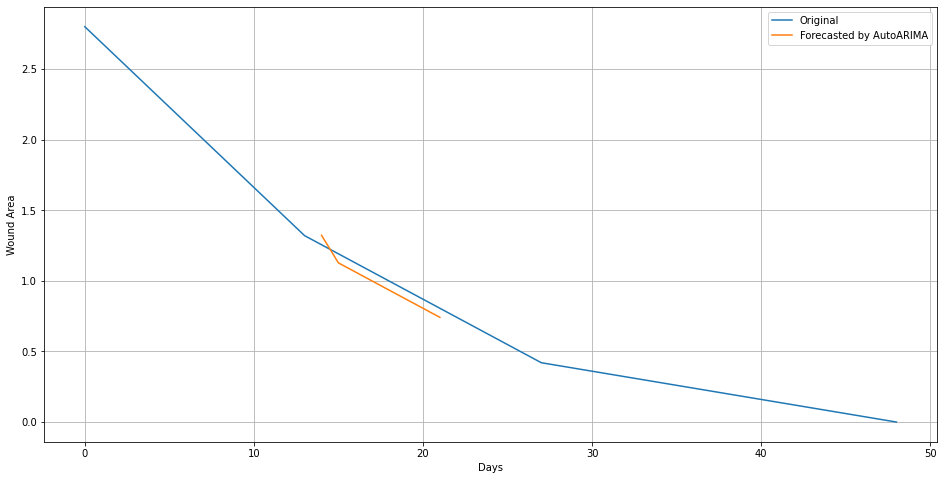

Wound: 47
26
38


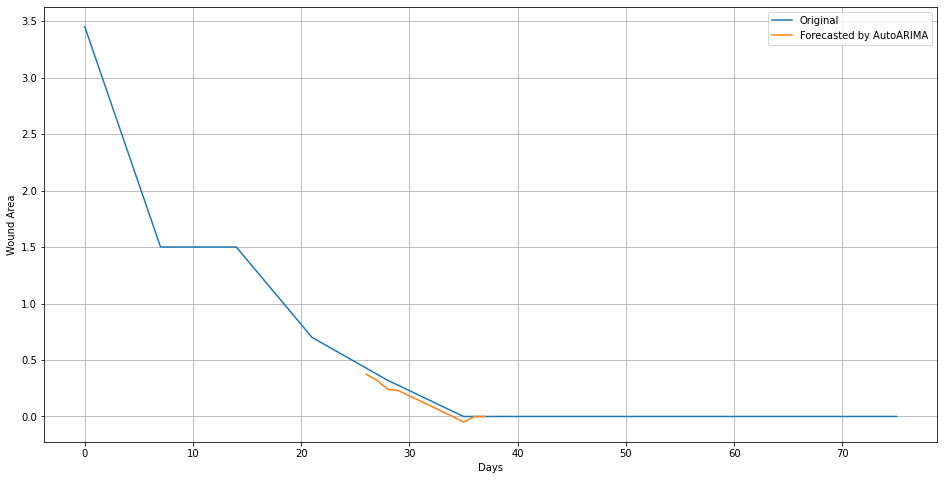

Wound: 48
19
36


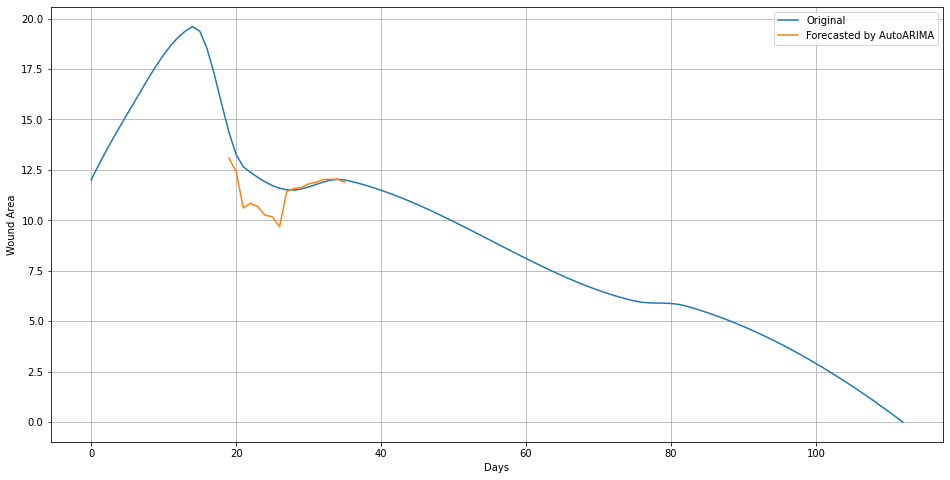

Wound: 49
53
69


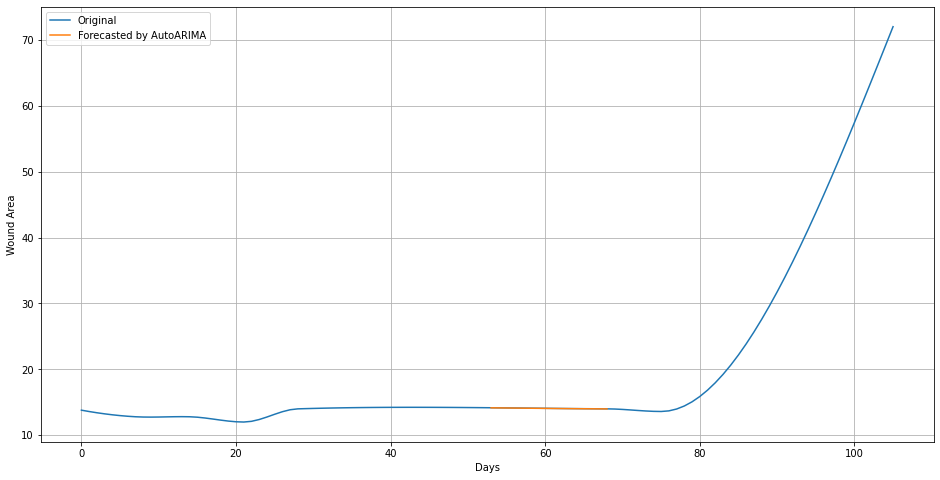

Wound: 50
13
21


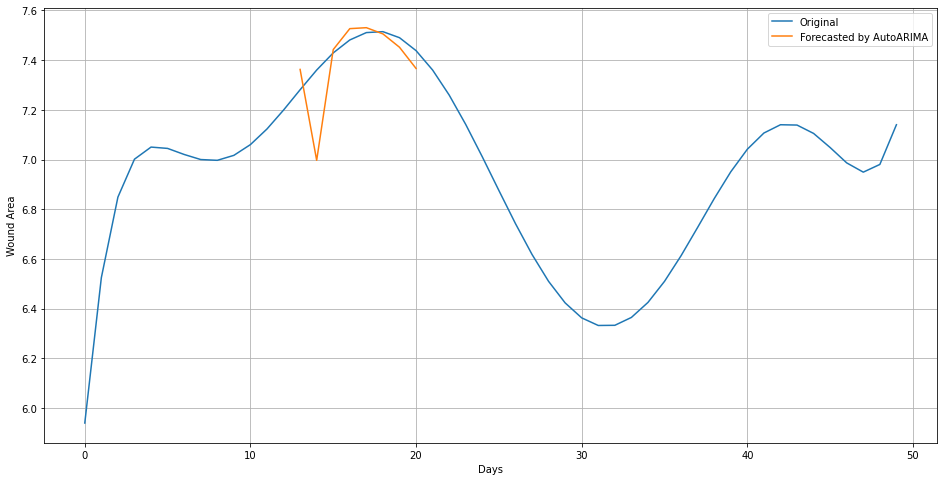

Wound: 51
19
28


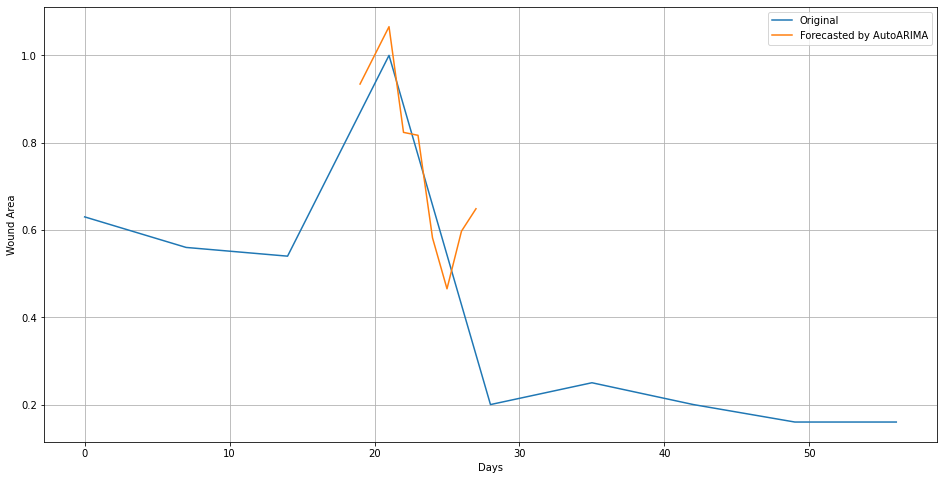

Wound: 52
13
17


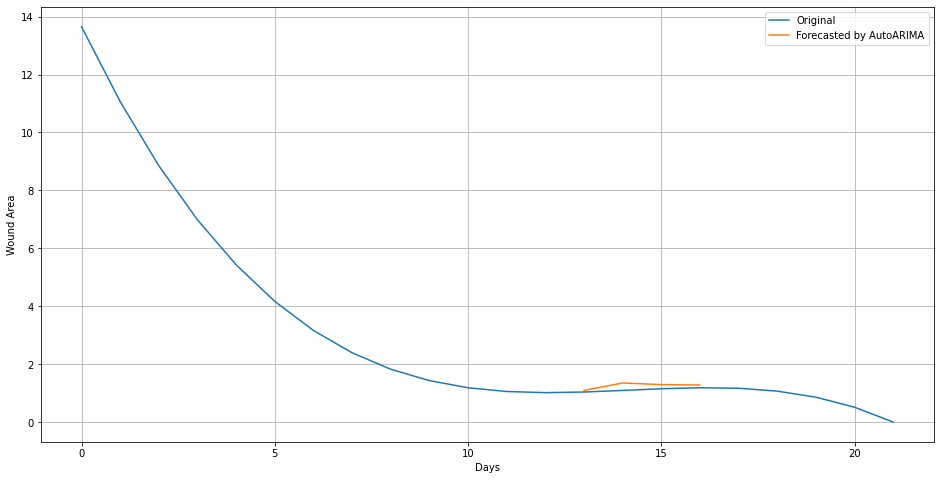

Wound: 53
9
15


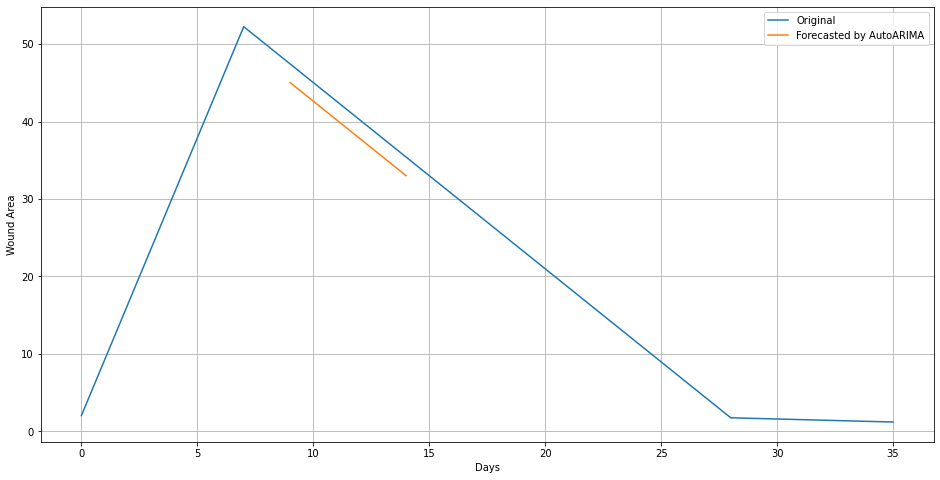

Wound: 54
10
13


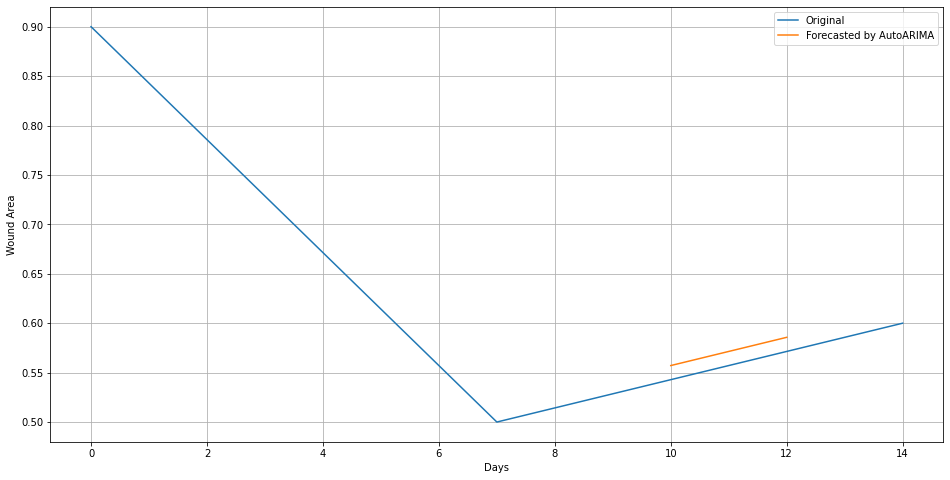

Wound: 55
Wound: 56
94
118


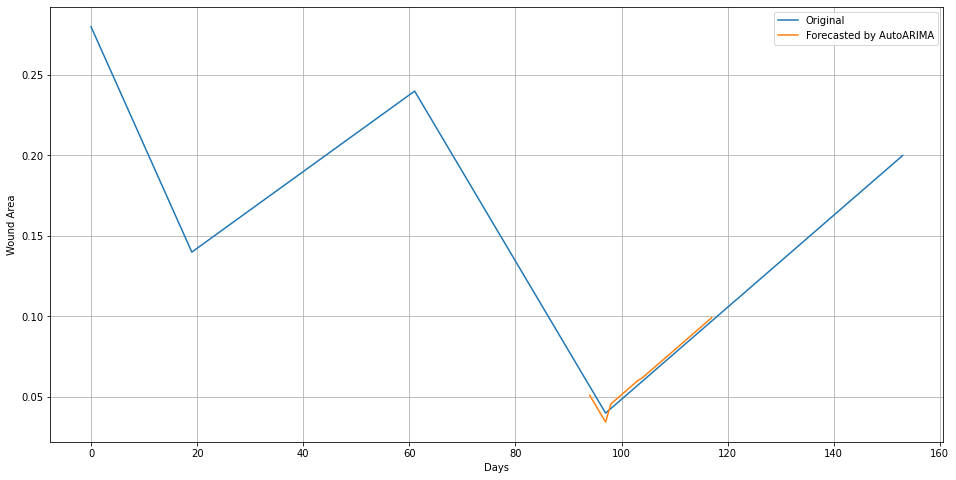

Wound: 57
41
51


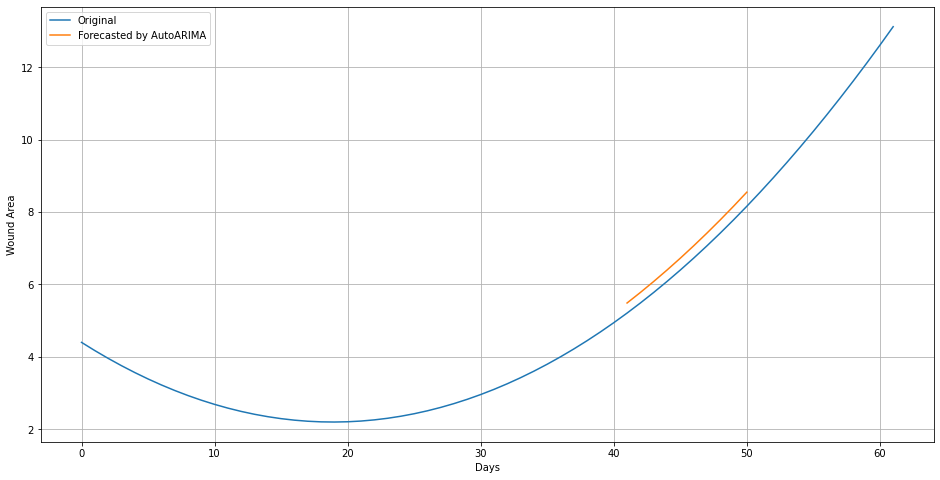

Wound: 58
95
119


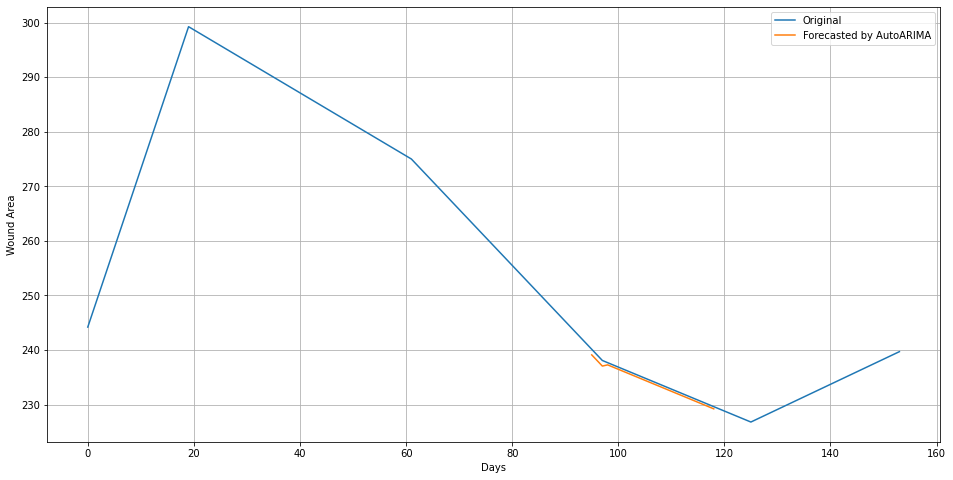

Wound: 59
101
122


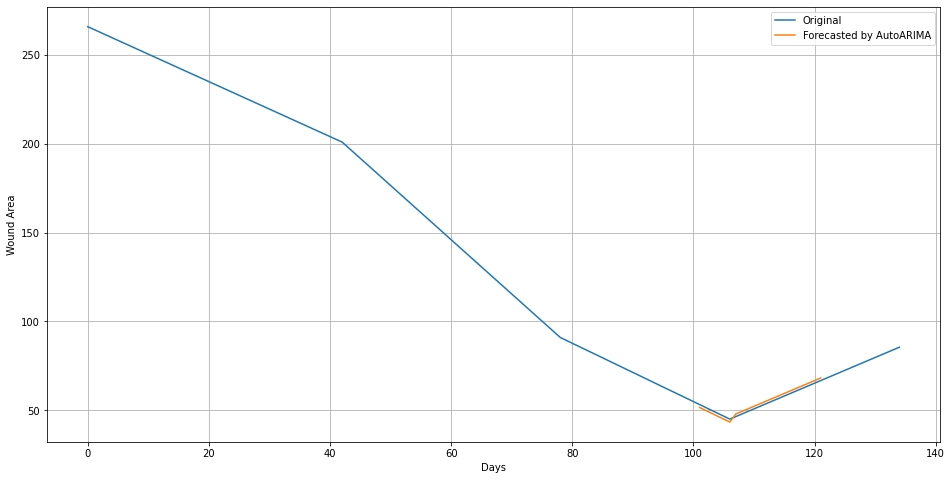

Wound: 60
52
73


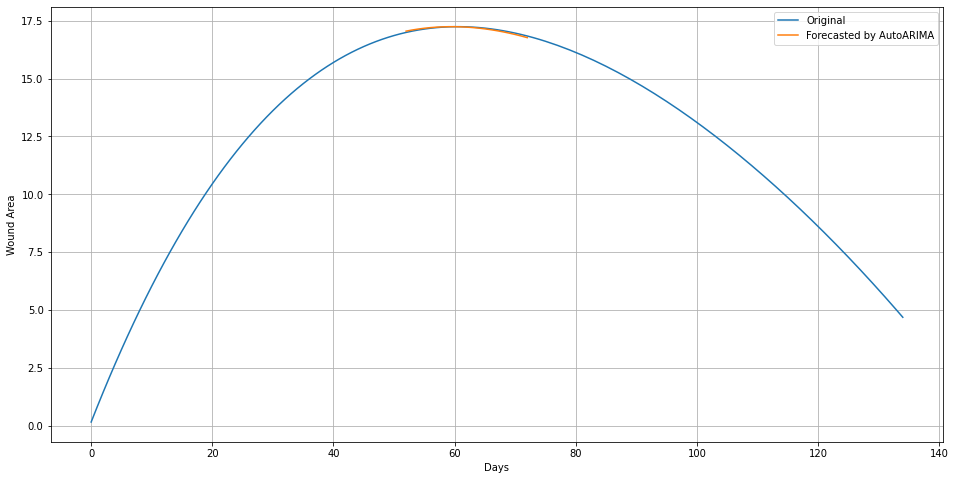

Wound: 61
Wound: 62
9
30


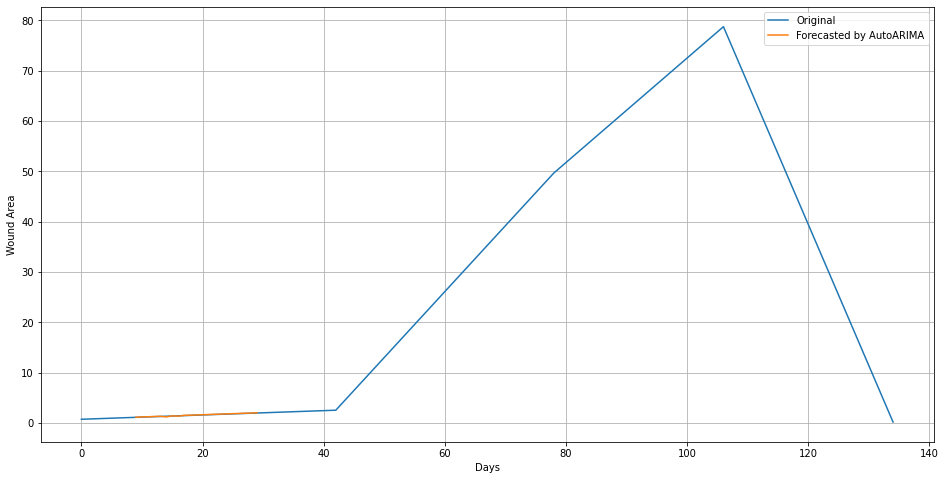

Wound: 63
68
82


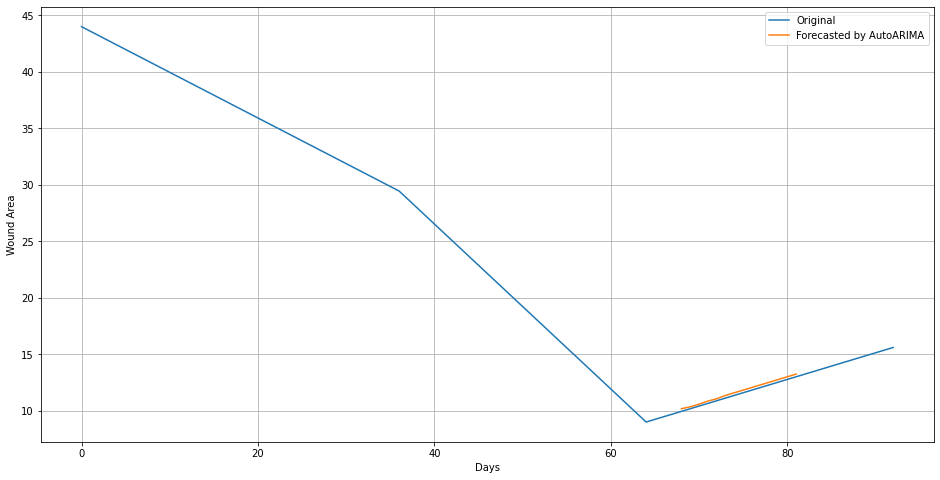

Wound: 64
12
21


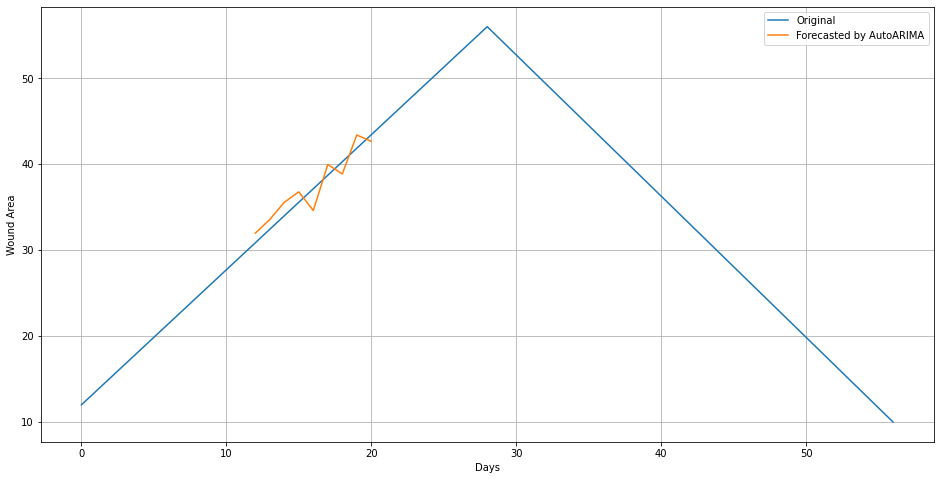

Wound: 65
315
416


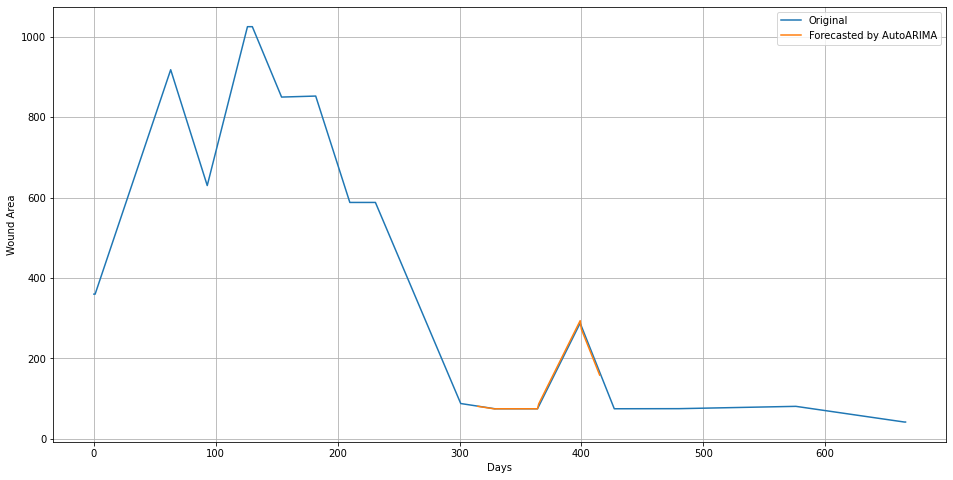

Wound: 66
498
599


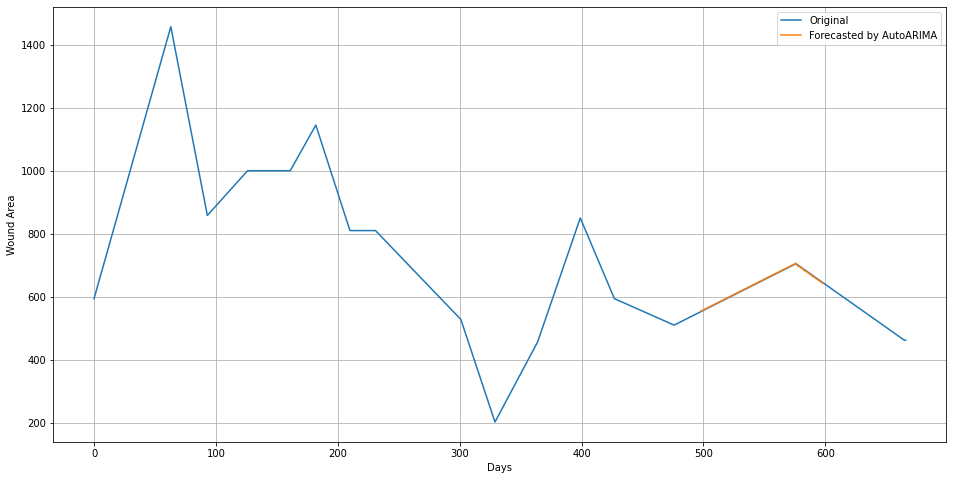

Wound: 67
335
407


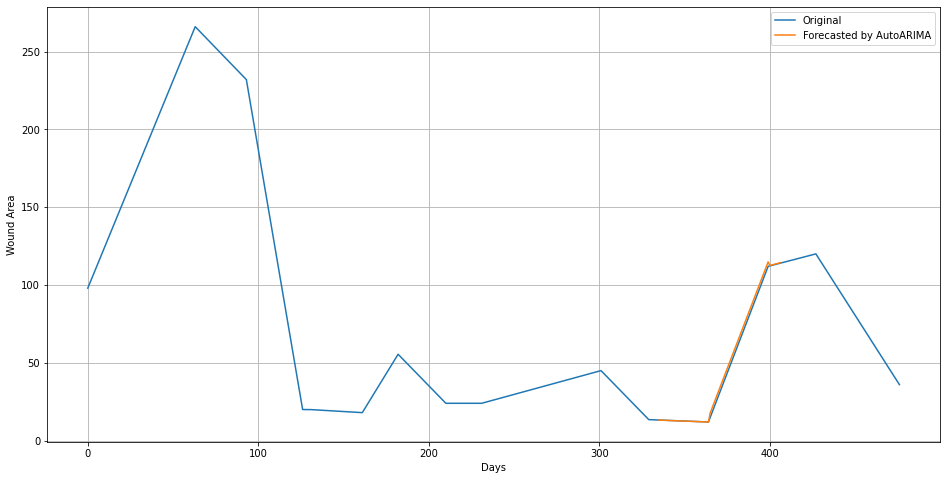

Wound: 68
78
110


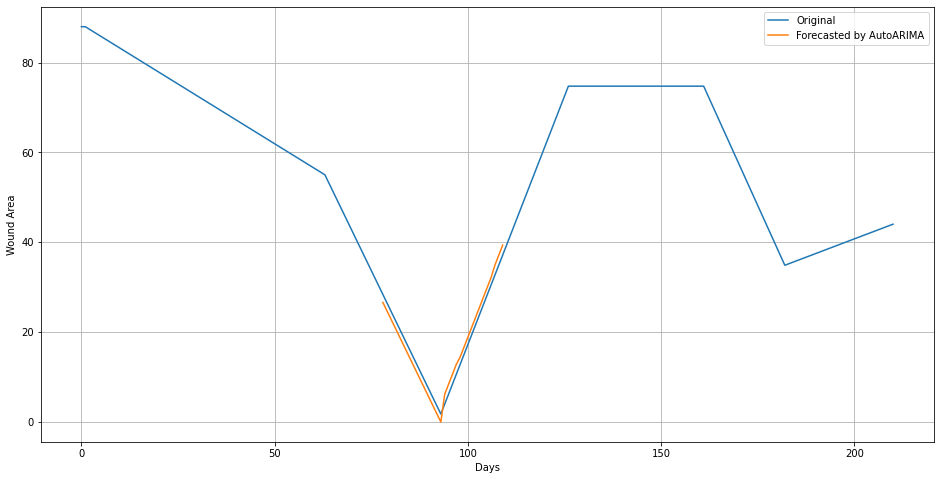

Wound: 69
393
515


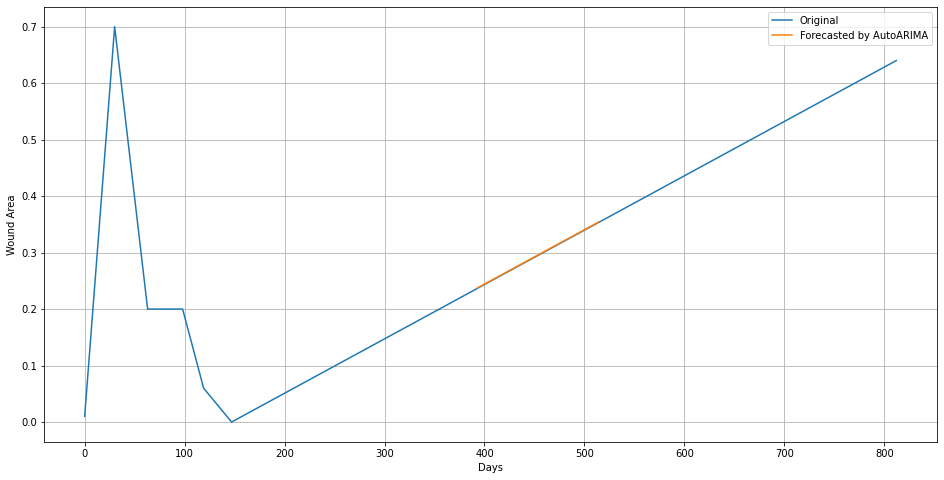

Wound: 70
87
115


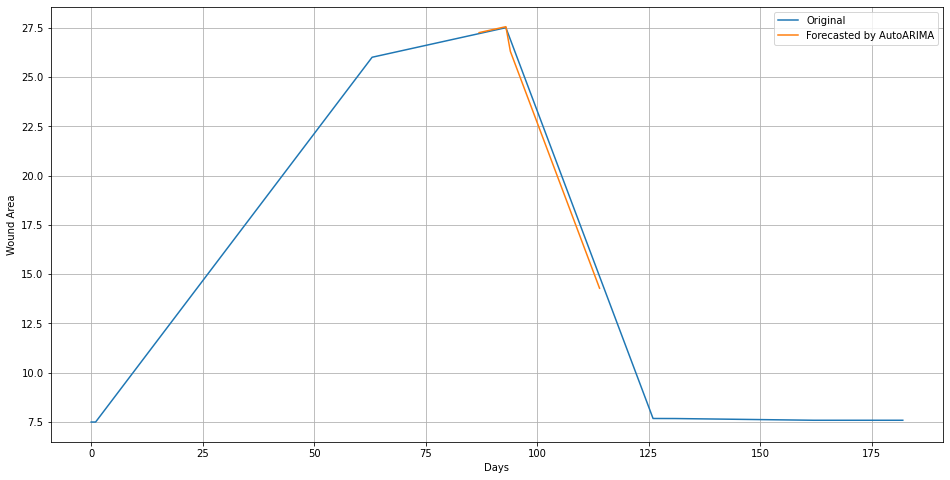

Wound: 71
27
59


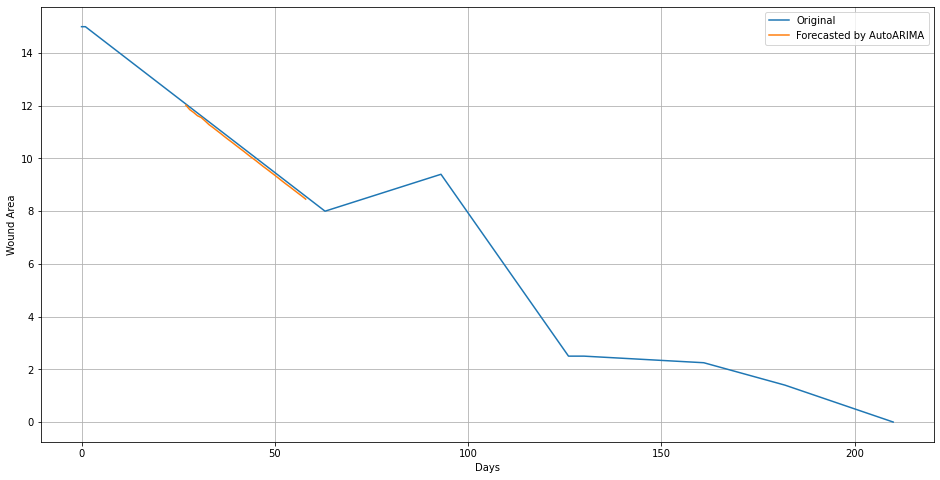

Wound: 72
20
34


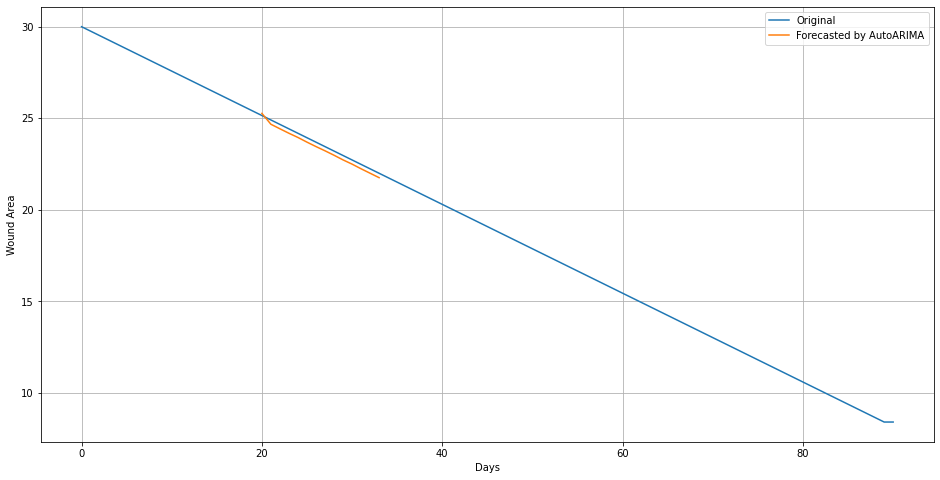

Wound: 73
50
64


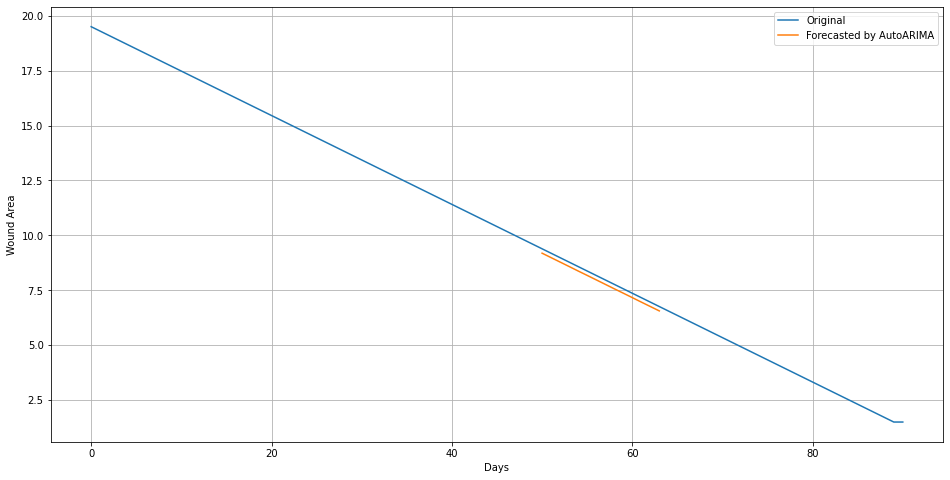

Wound: 74
49
63


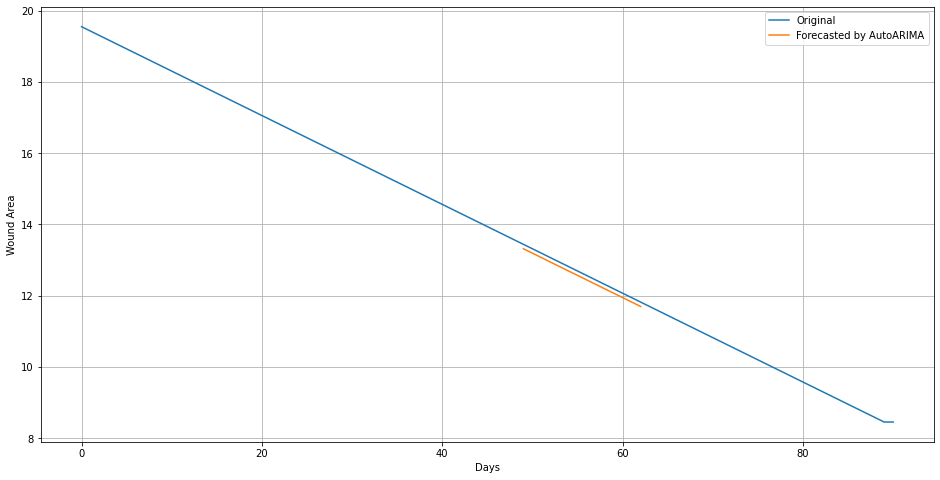

Wound: 75
Wound: 76
93
121


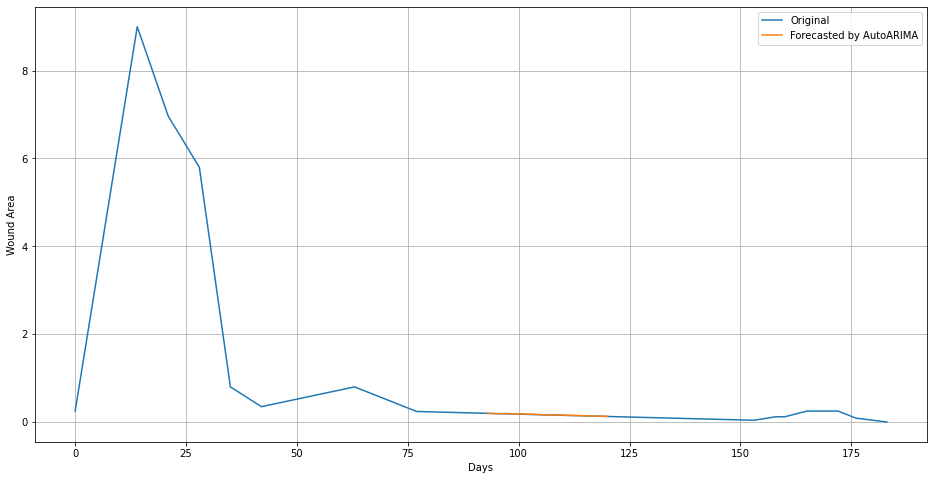

Wound: 77
5
9


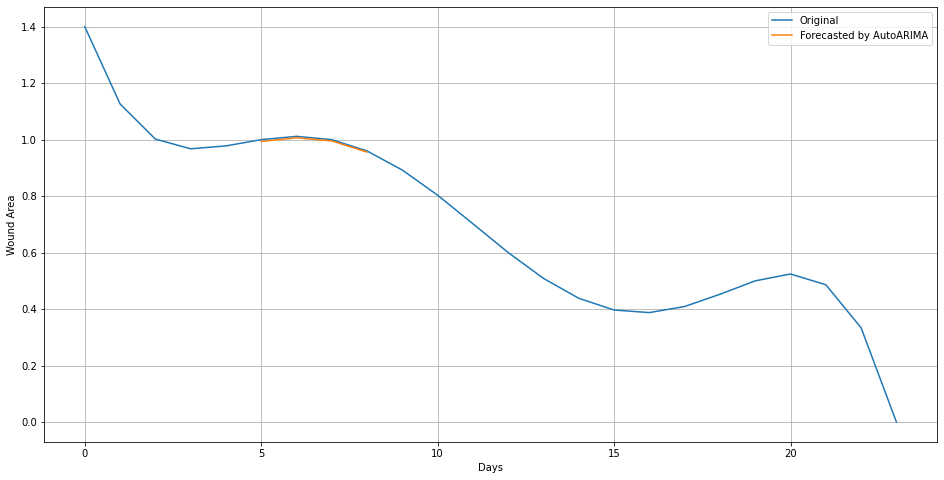

Wound: 78
4
7


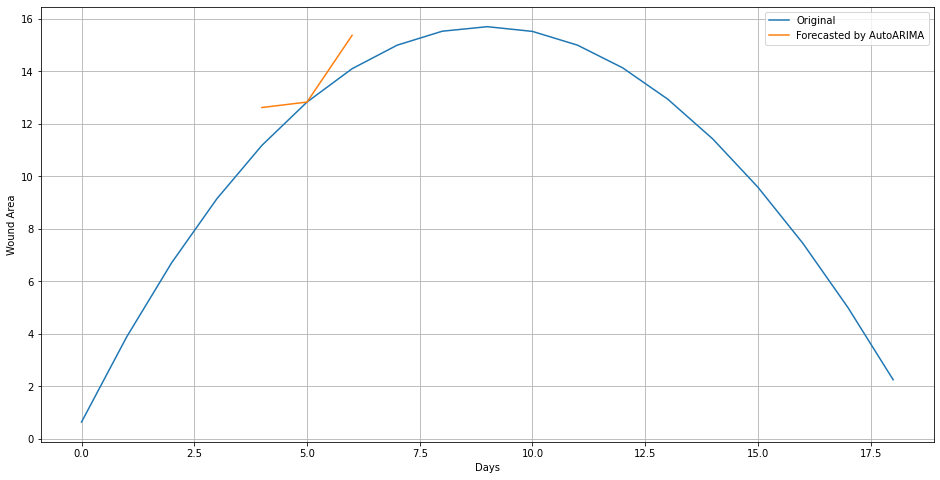

Wound: 79
3
4


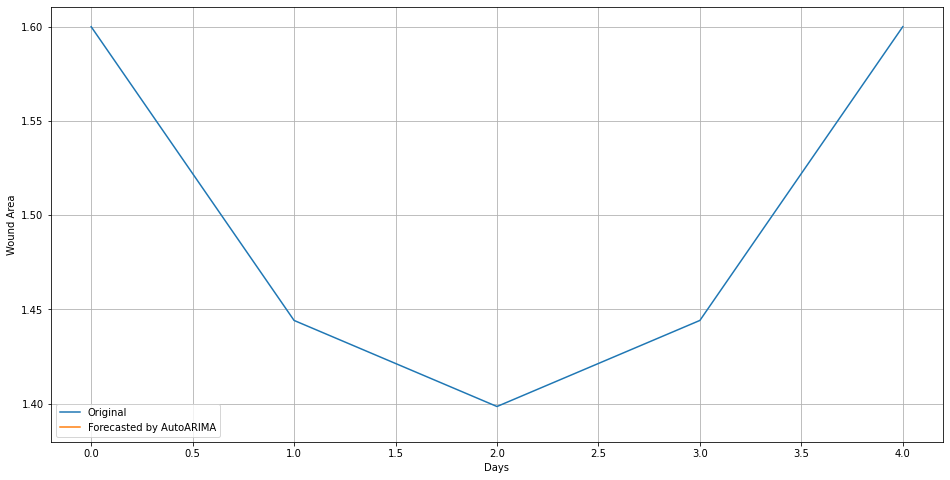

Wound: 80
26
38


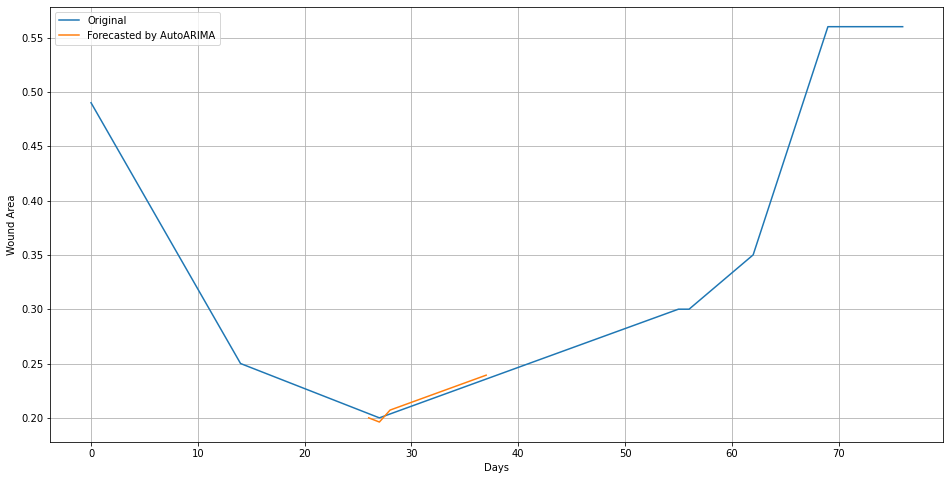

Wound: 81
50
62


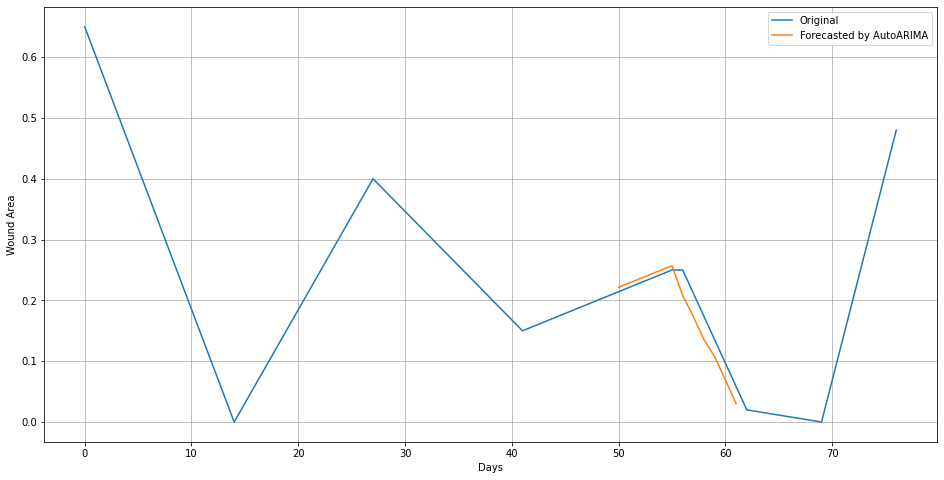

Wound: 82
117
161


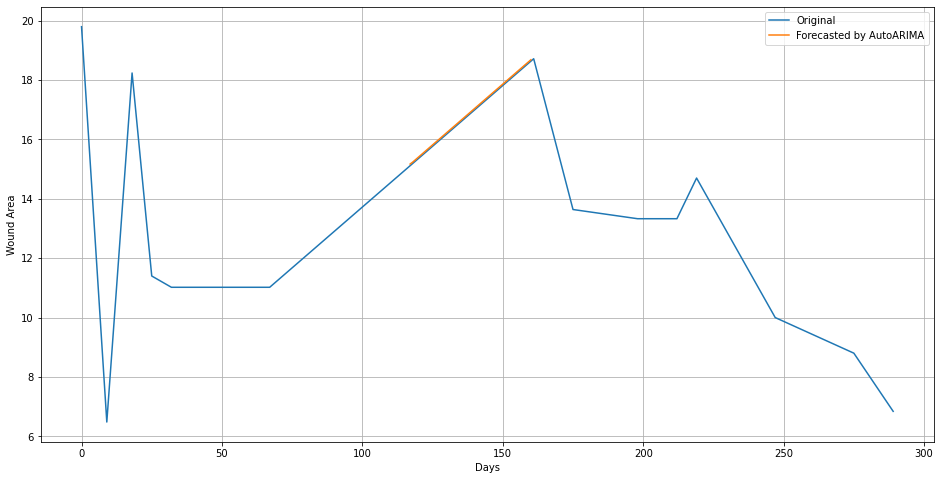

Wound: 83
14
19


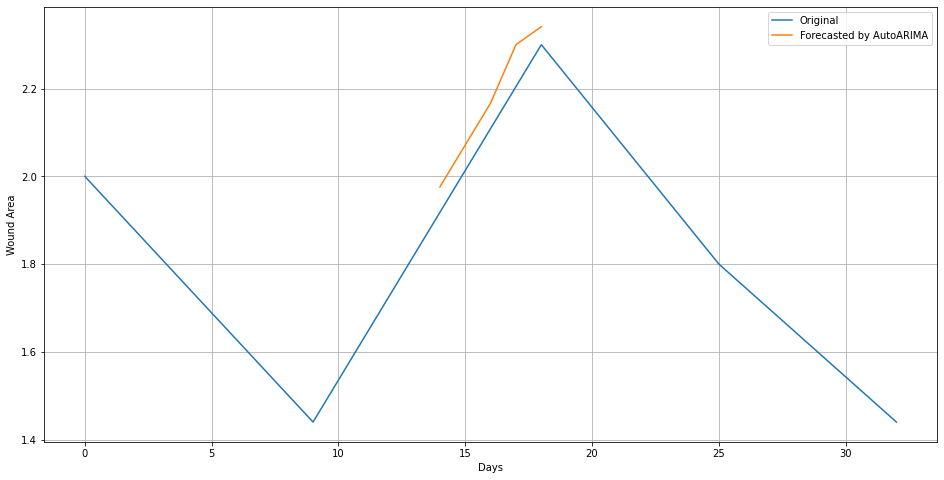

Wound: 84
14
21


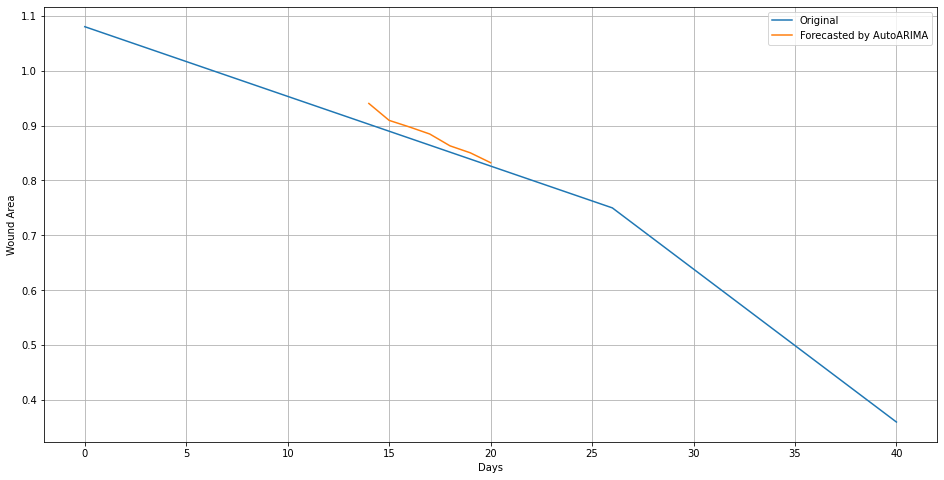

Wound: 85
23
30


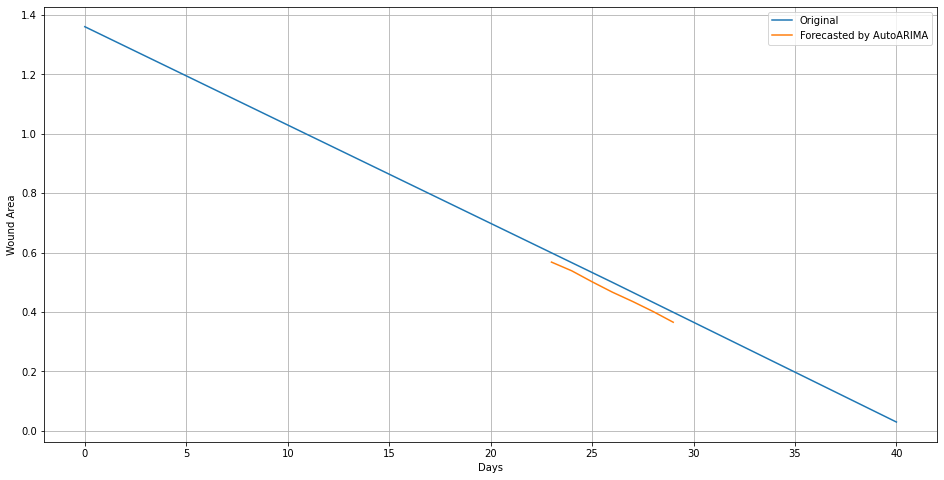

Wound: 86
Wound: 87
32
40


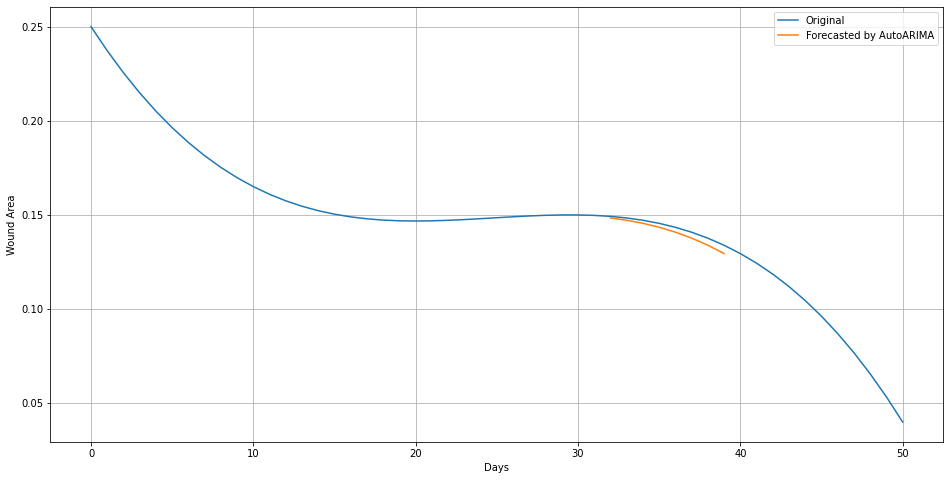

Wound: 88
8
12


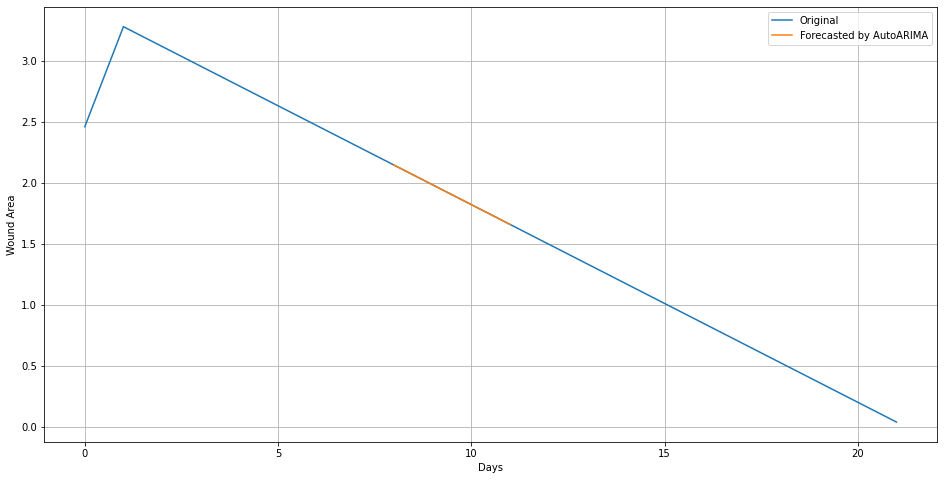

Wound: 89
2
5


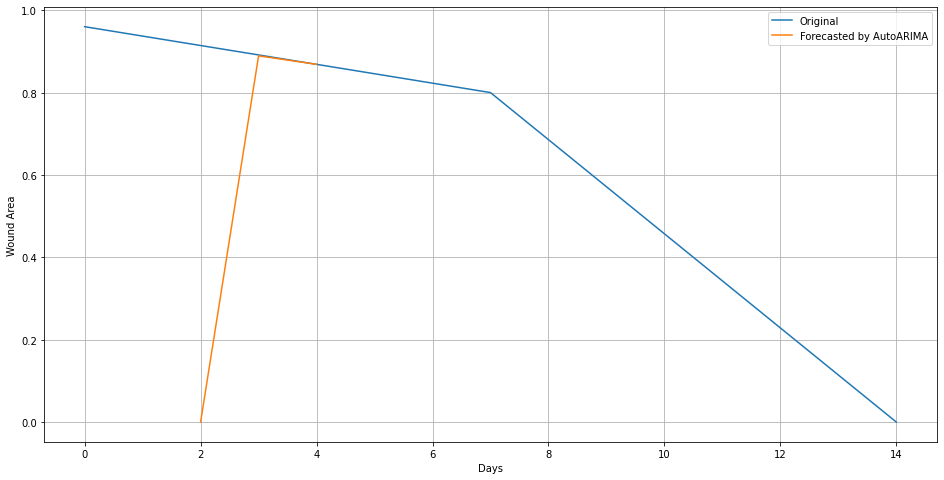

Wound: 90
2
6


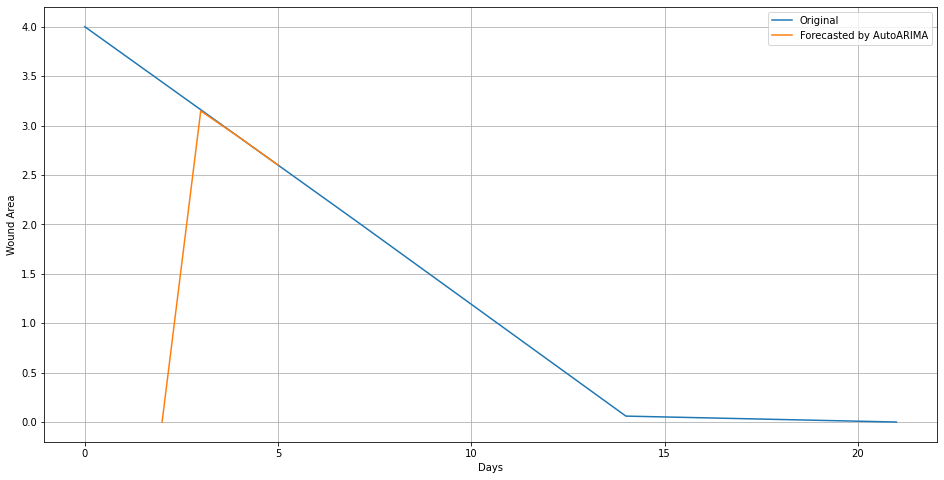

Wound: 91
25
31


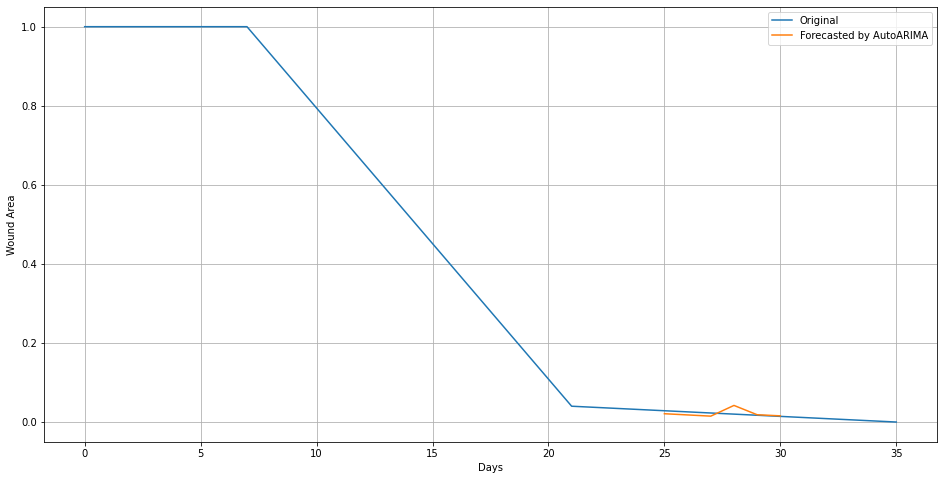

Wound: 92
137
166


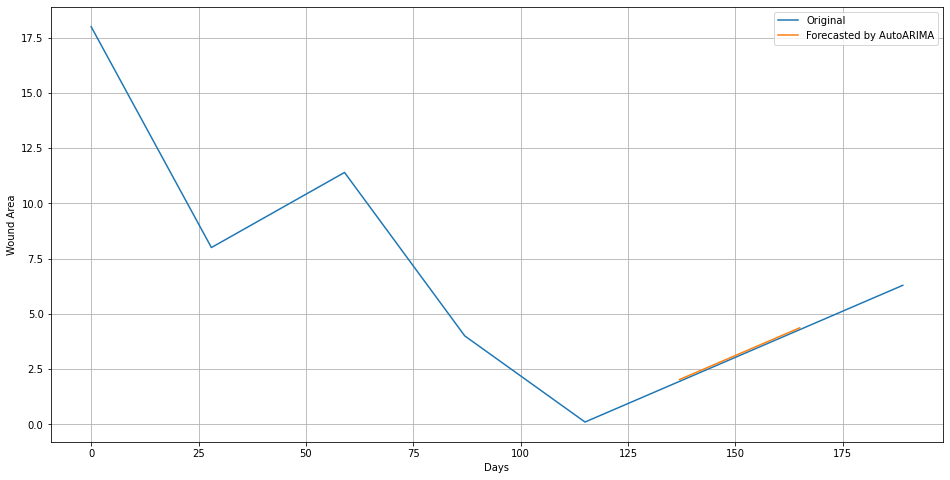

Wound: 93
Wound: 94
Wound: 95
31
94


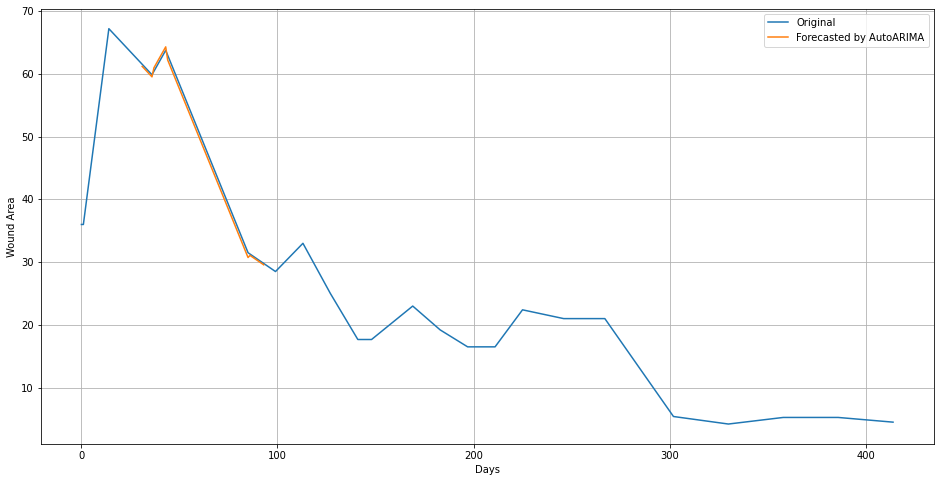

Wound: 96
7
12


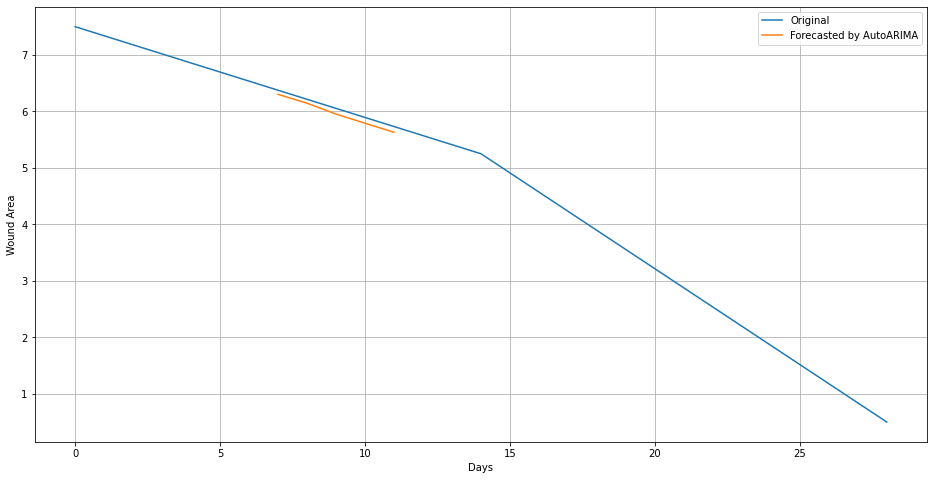

Wound: 97
22
30


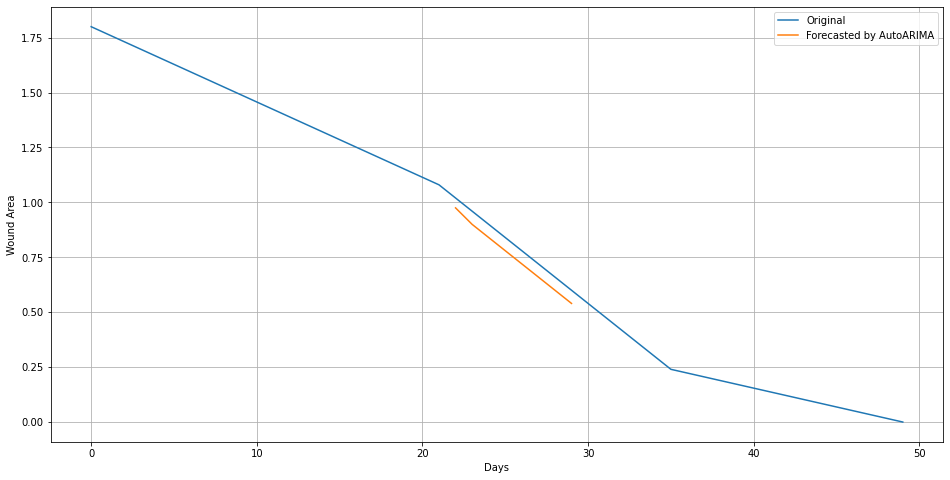

Wound: 98
9
13


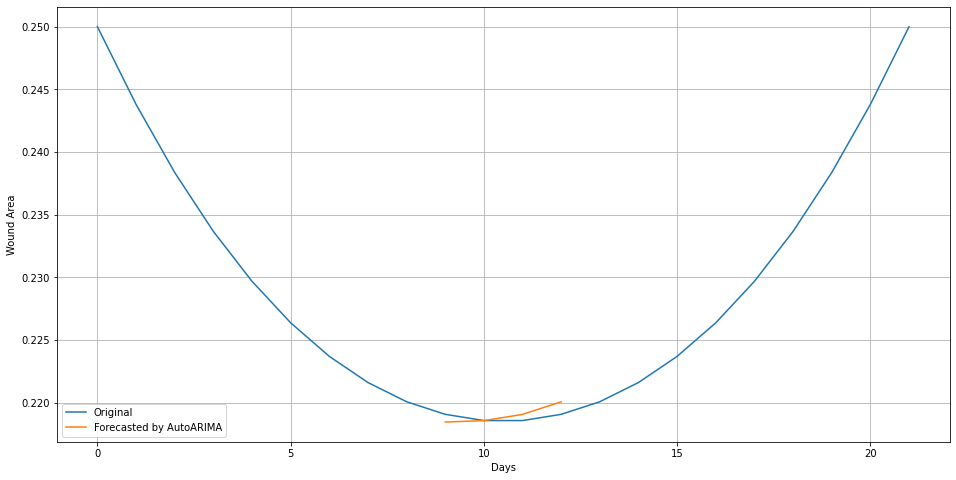

Wound: 99
30
43


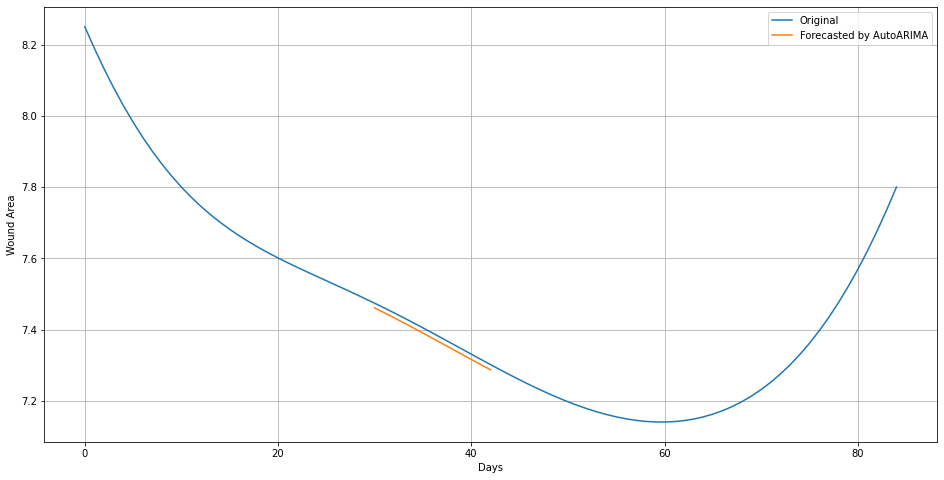

Wound: 100
81
104


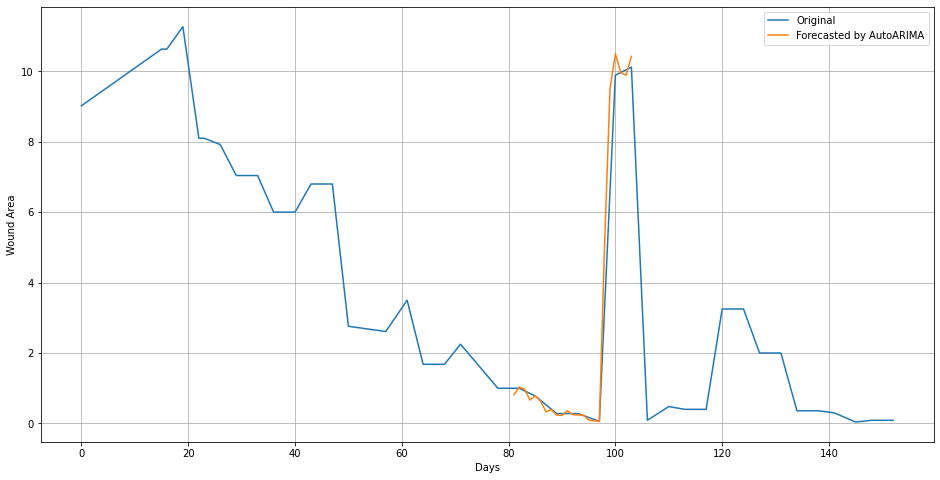

Wound: 101
577
747


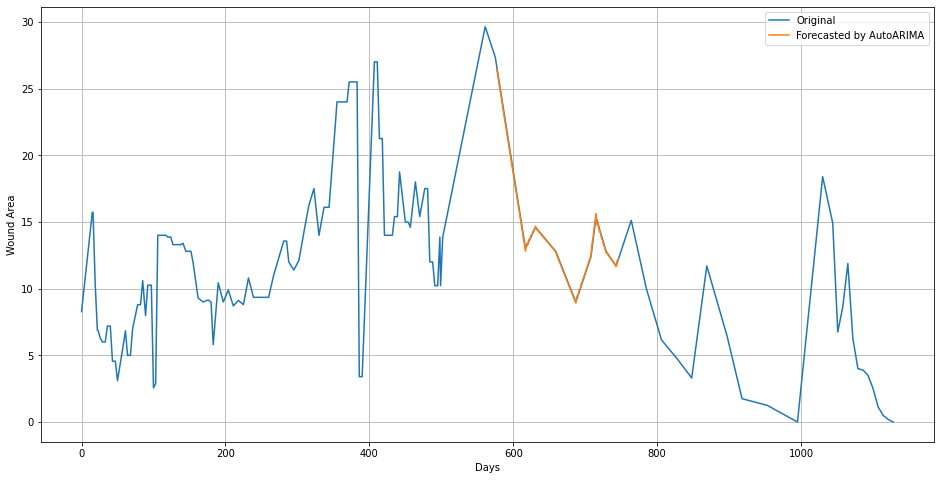

Wound: 102
447
601


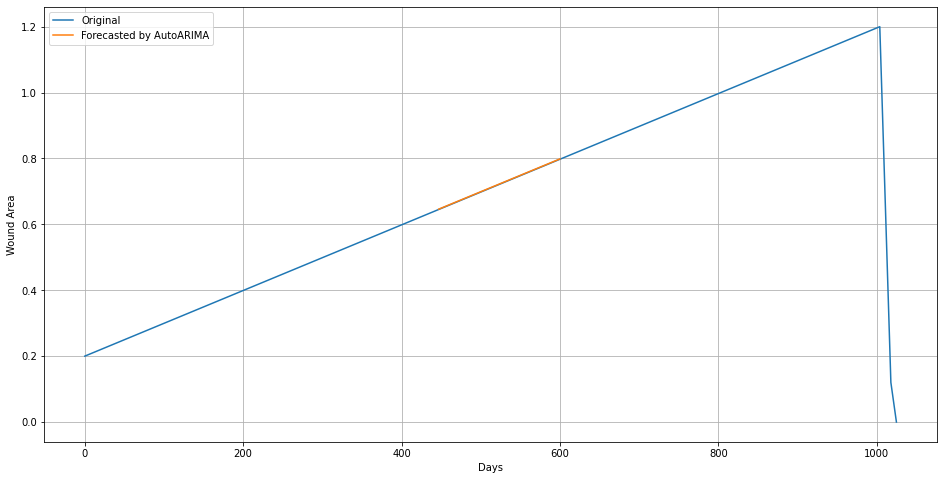

Wound: 103
11
15


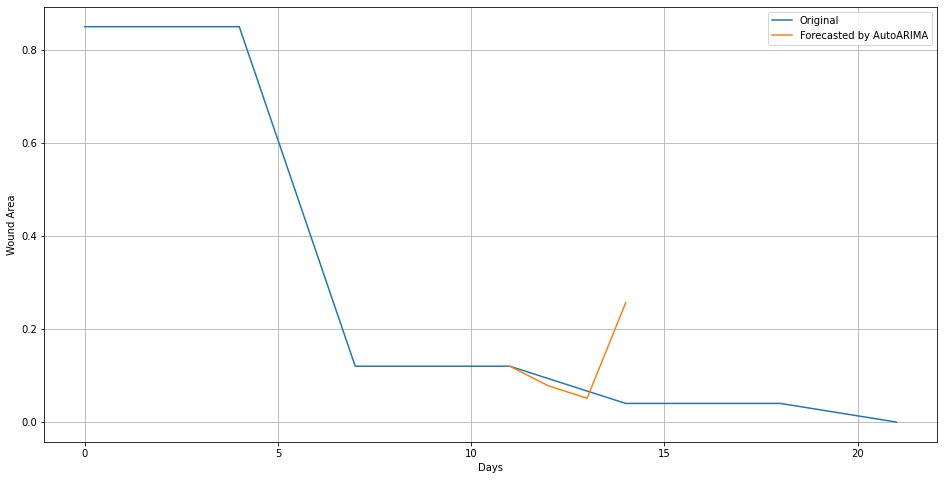

Wound: 104
5
8


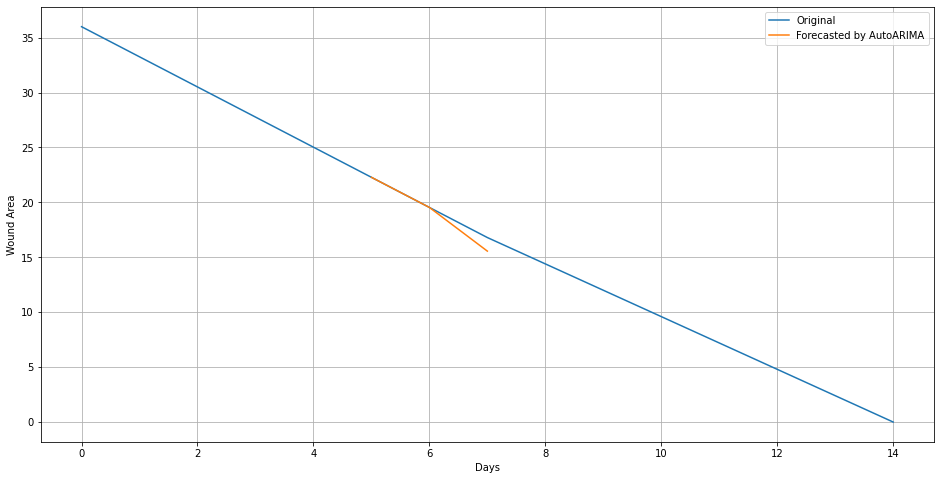

Wound: 105
313
372


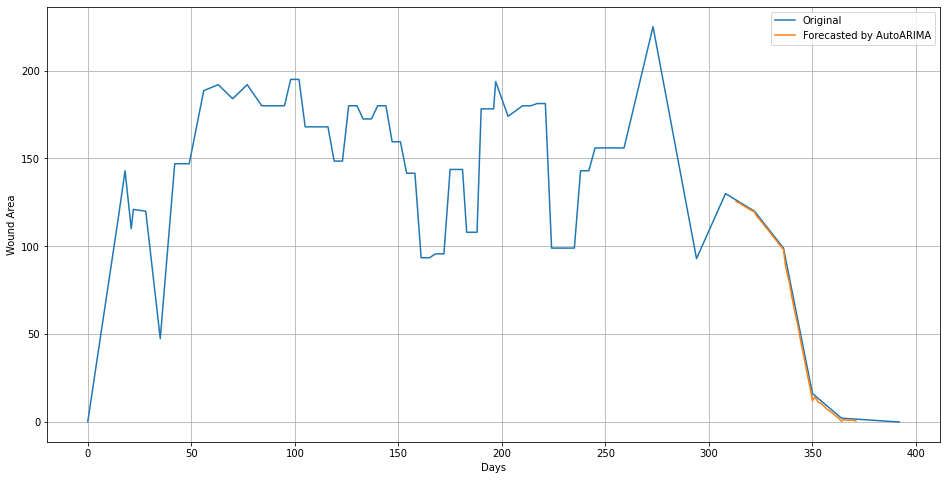

Wound: 106
107
142


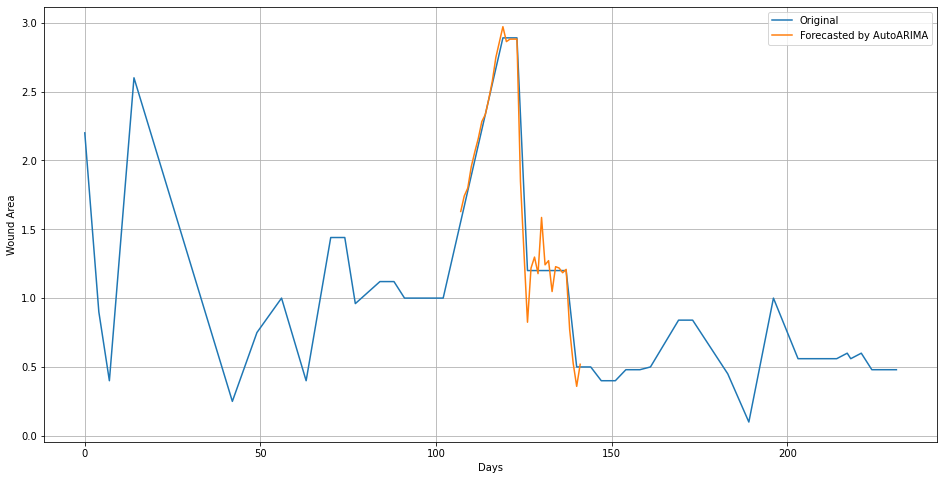

Wound: 107
10
22


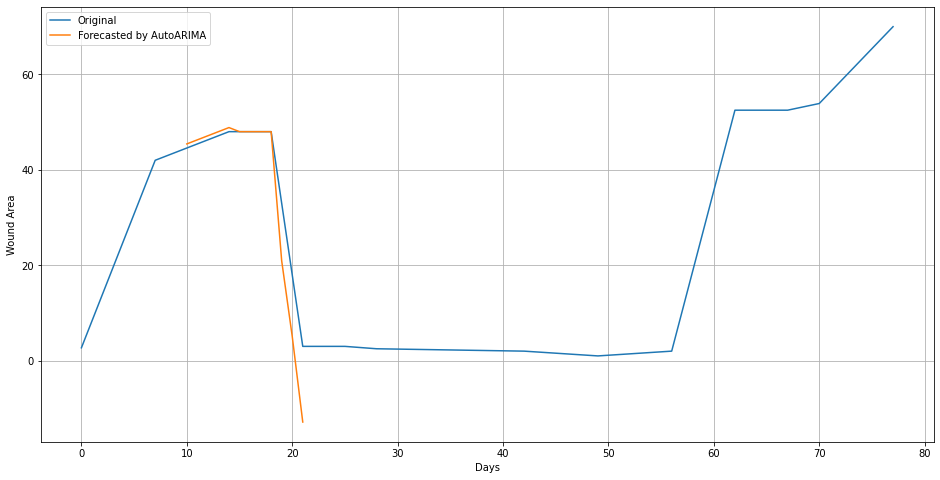

Wound: 108
21
32


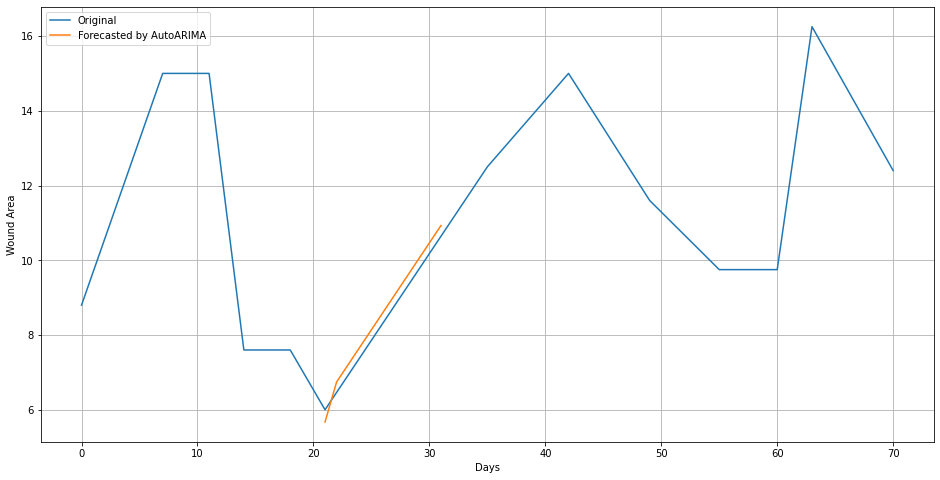

Wound: 109
7
12


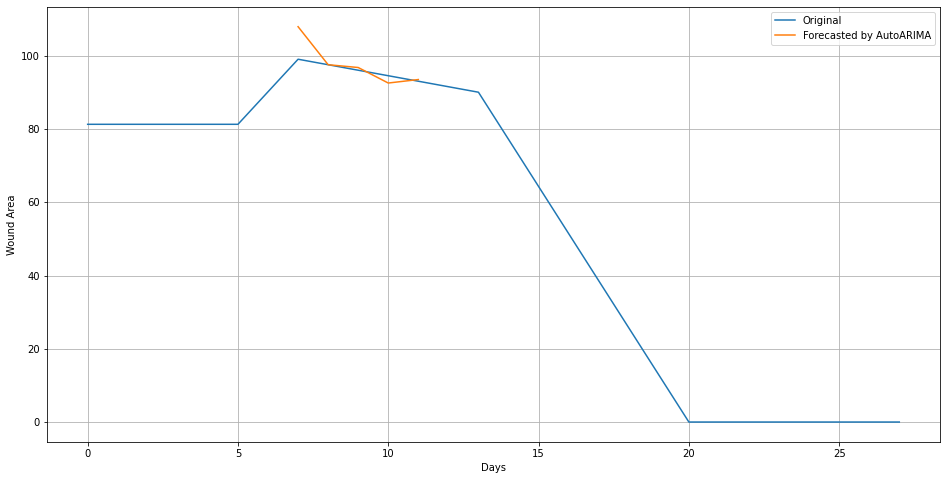

Wound: 110
53
64


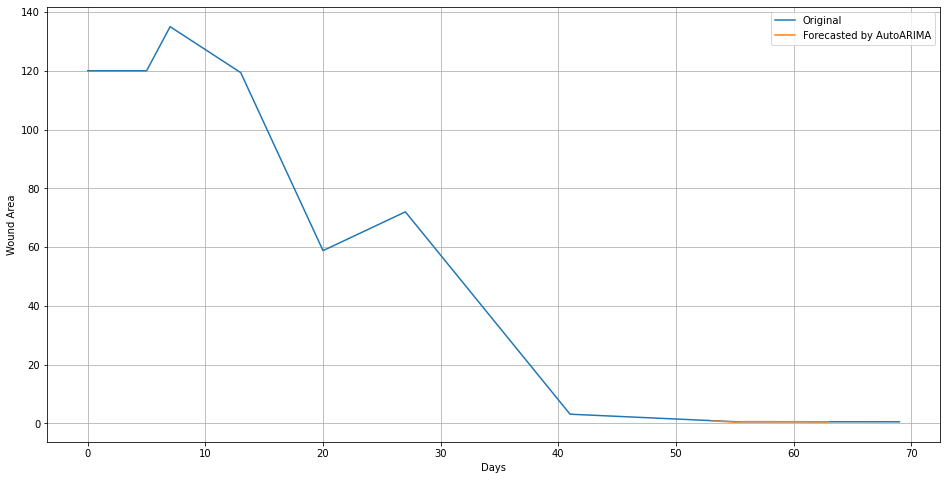

Wound: 111
355
422


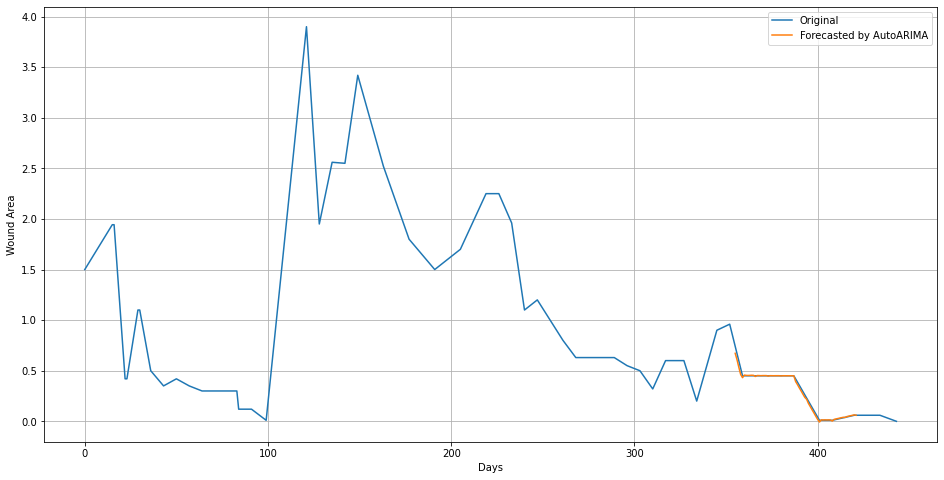

Wound: 112
4
7


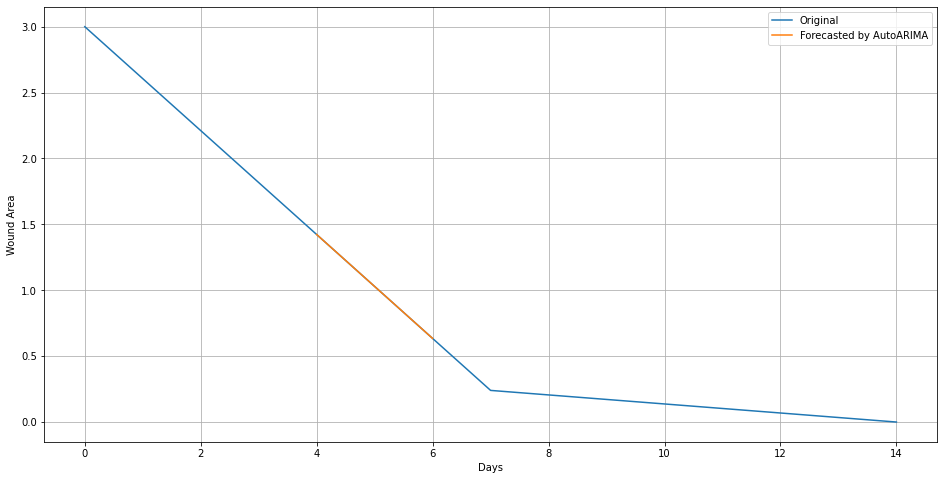

Wound: 113
2
9


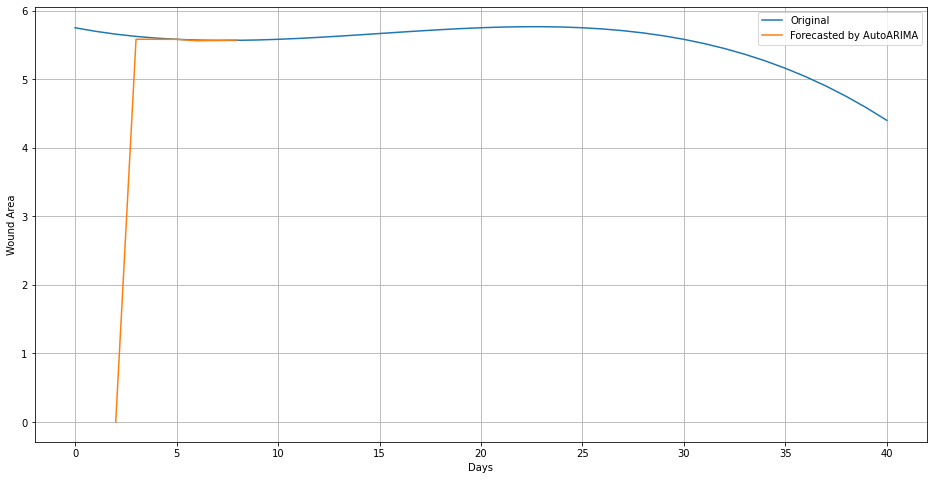

Wound: 114
9
15


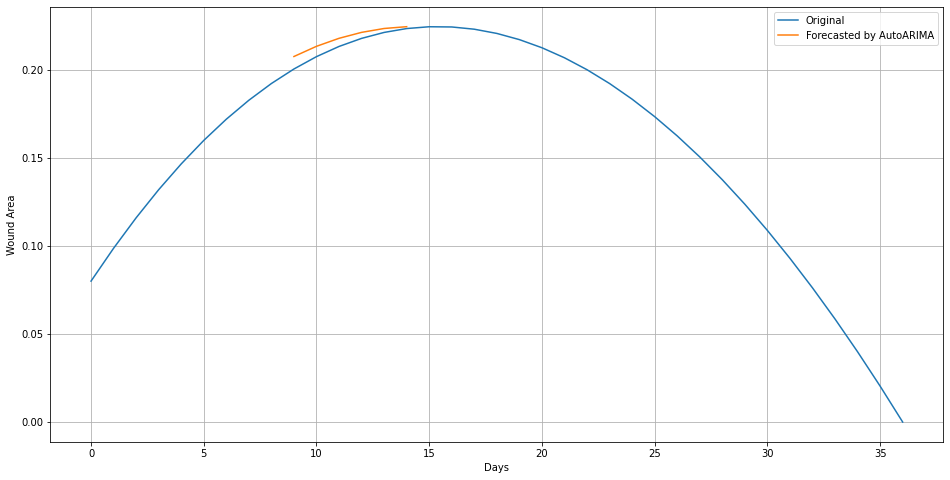

Wound: 115
20
27


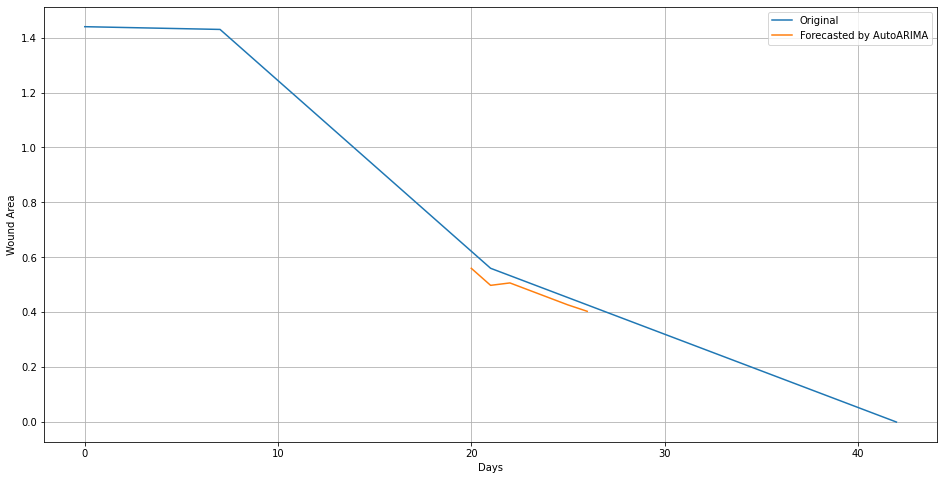

Wound: 116
29
35


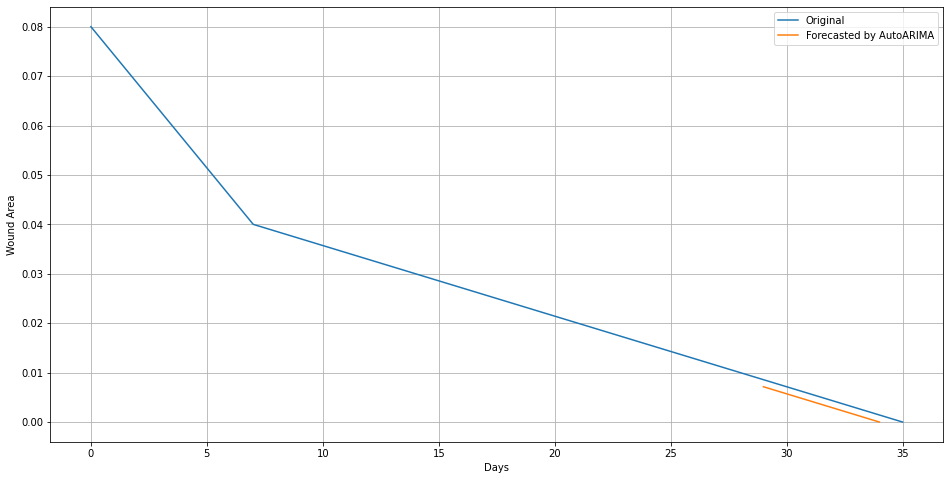

Wound: 117
69
83


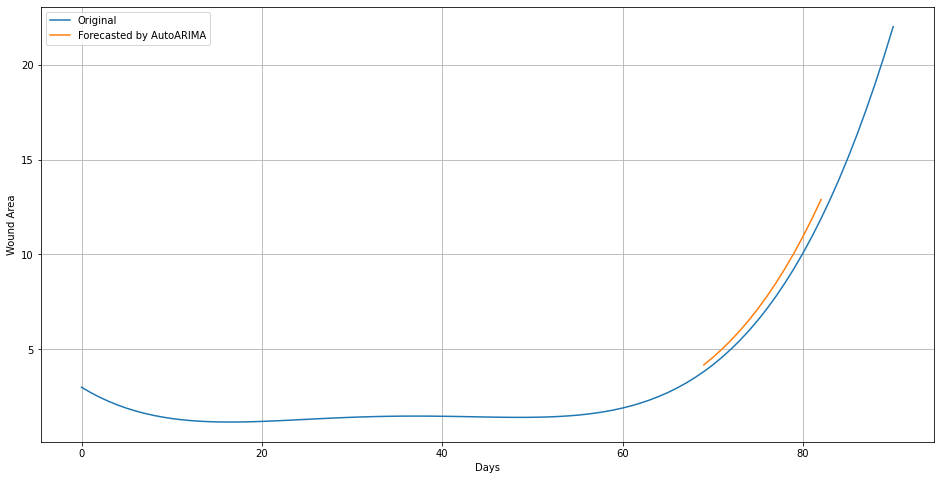

Wound: 118
23
28


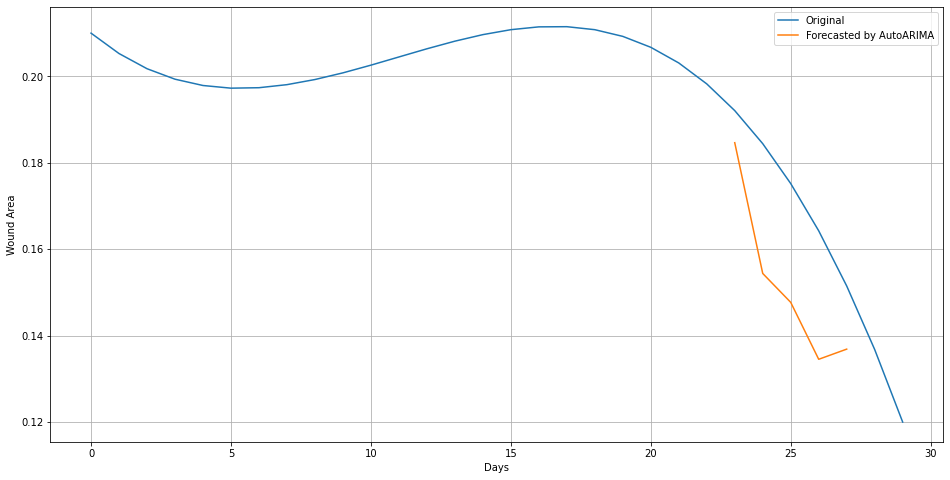

Wound: 119
28
34


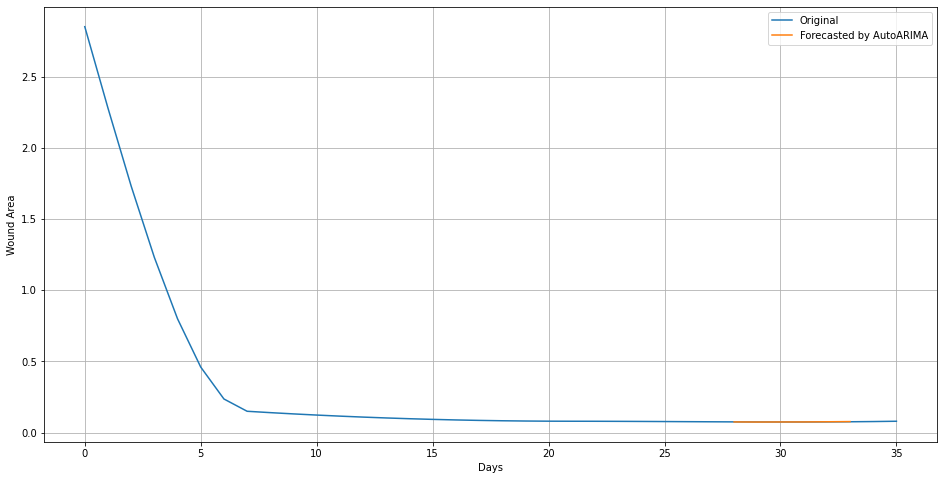

Wound: 120
11
15


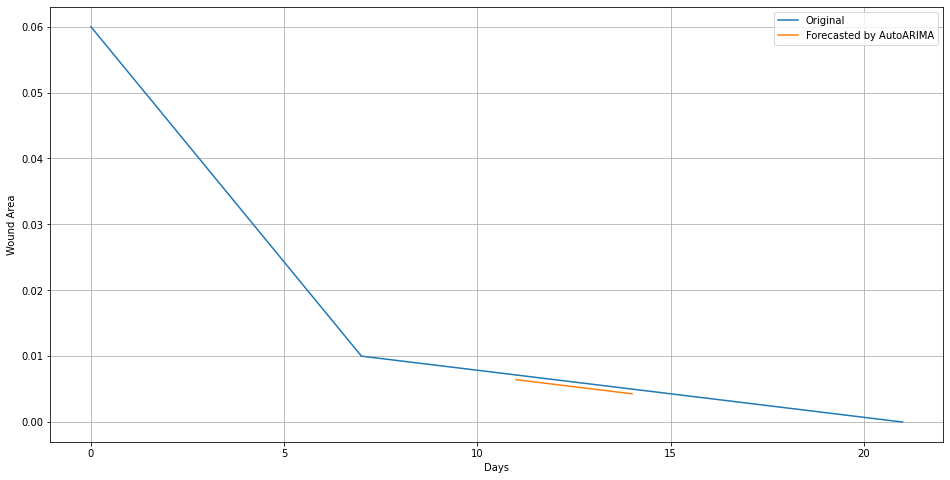

Wound: 121
17
23


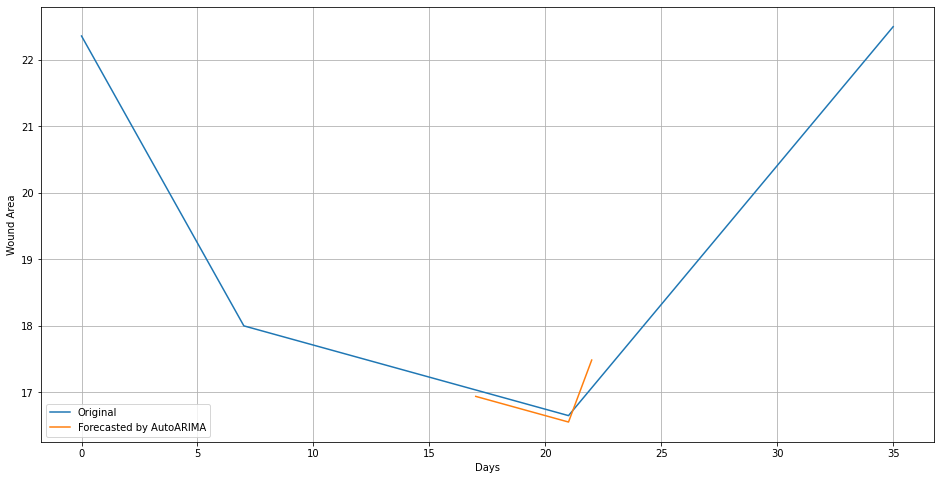

Wound: 122
122
167


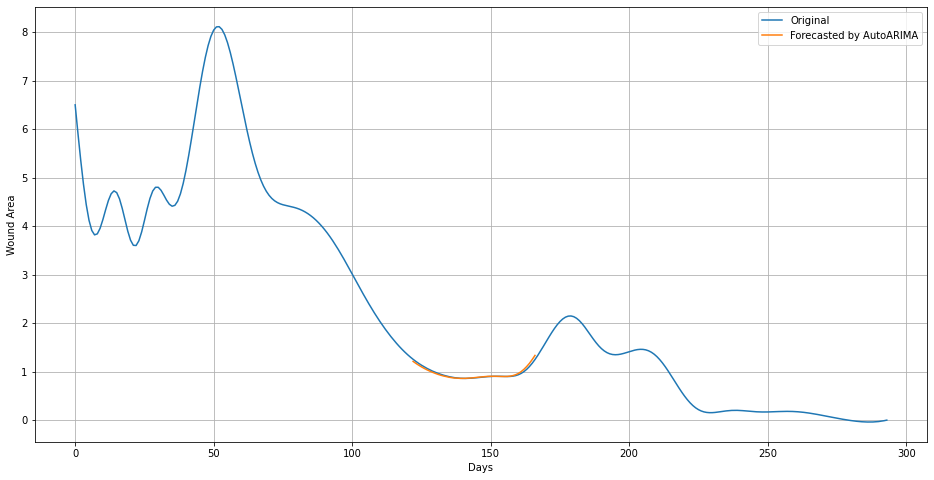

Wound: 123
10
24


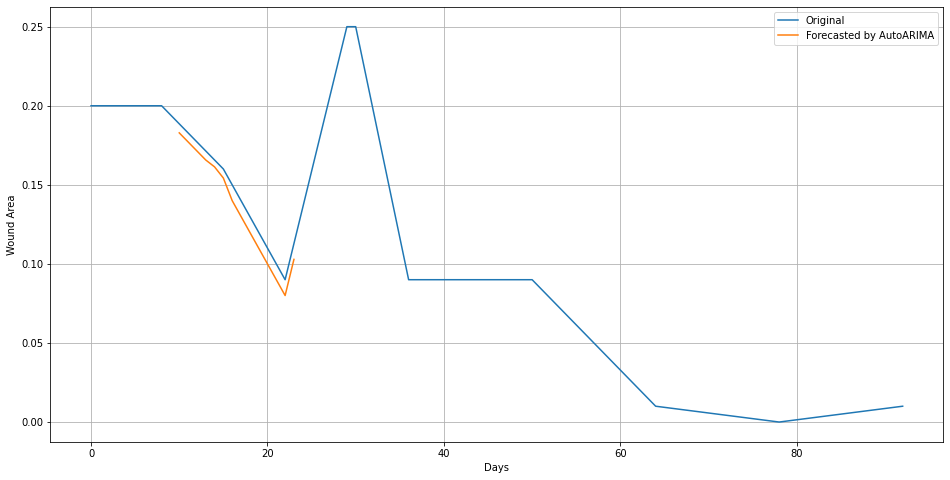

Wound: 124
75
100


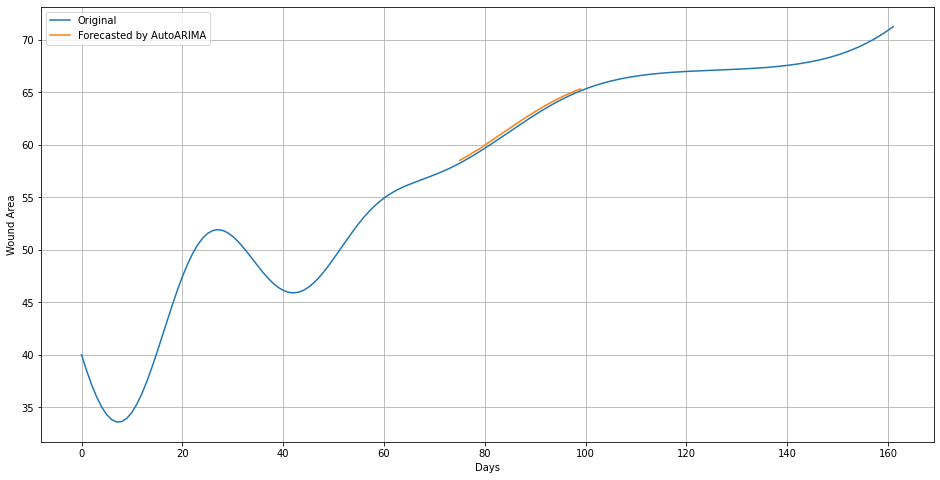

Wound: 125
24
32


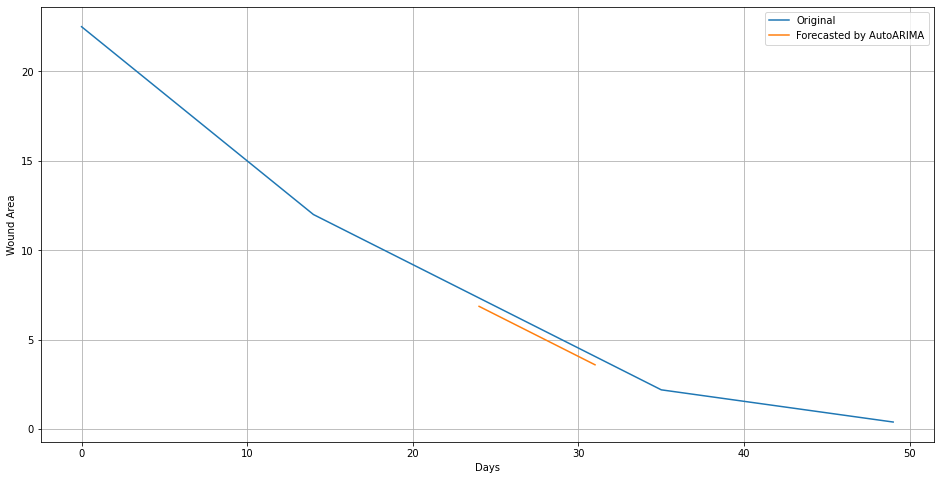

Wound: 126
2
8


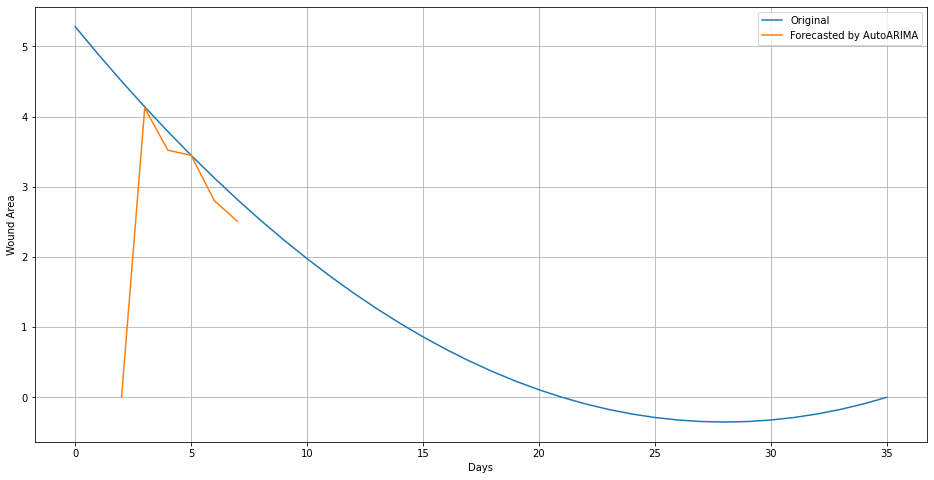

Wound: 127
30
38


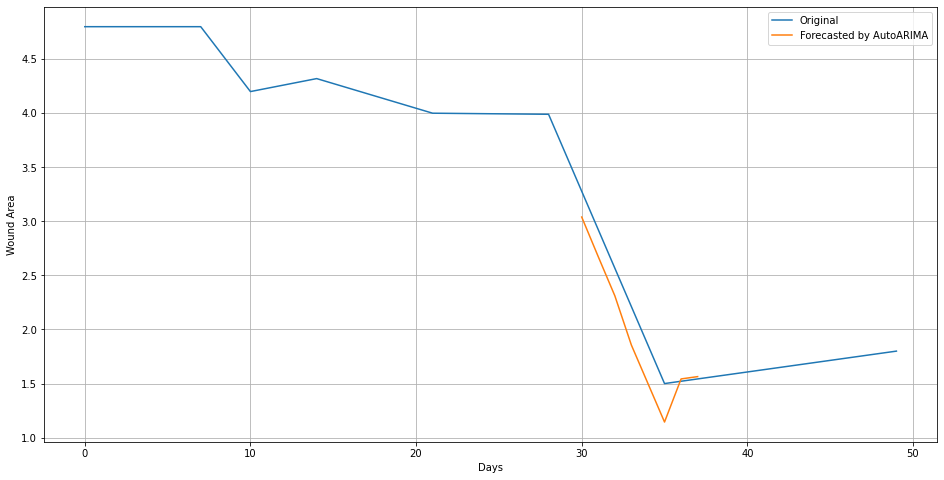

Wound: 128
11
14


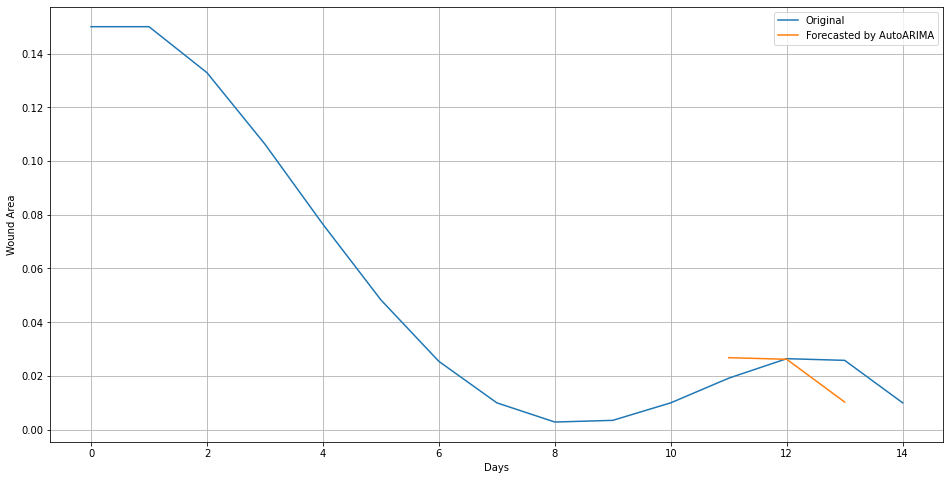

Wound: 129
18
31


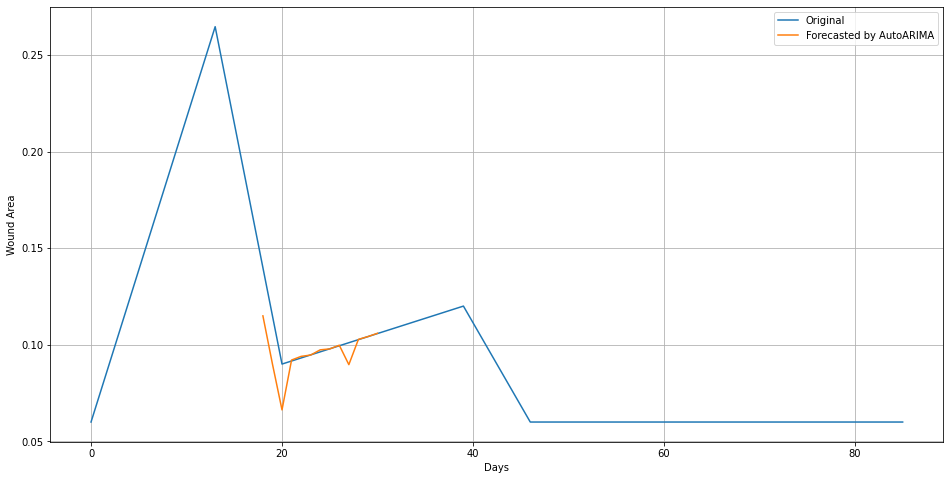

Wound: 130
120
146


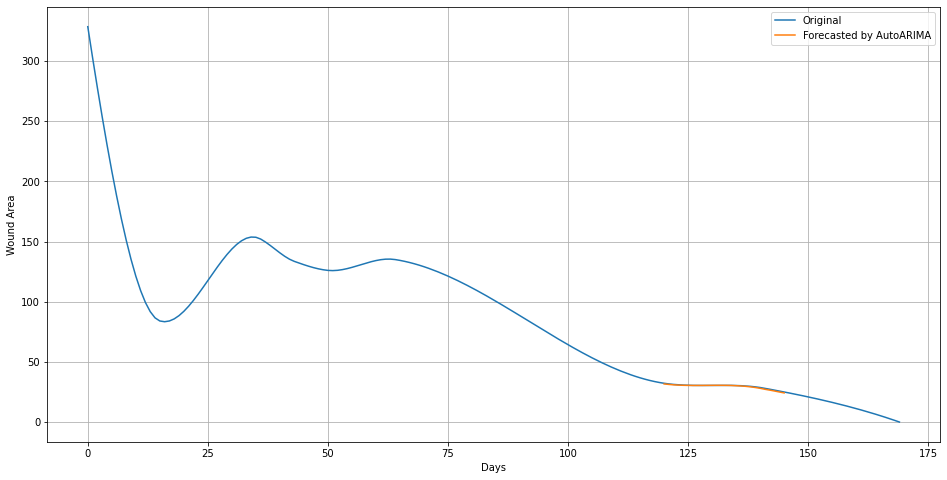

Wound: 131
2
8


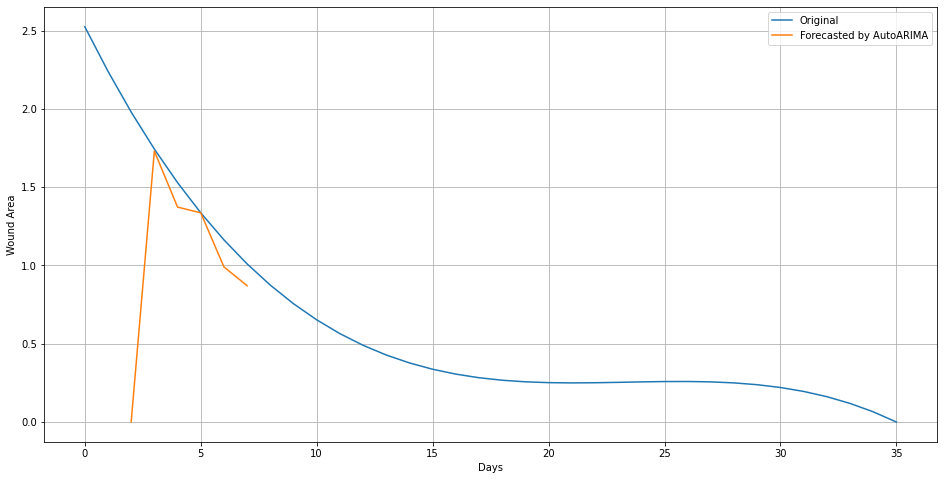

Wound: 132
23
29


KeyboardInterrupt: 

In [14]:
list_wounds=df_for["Wound"].unique()

result_df=pd.DataFrame(index=np.arange(len(list_wounds)))

result_df["Wound"]=np.nan
result_df["Gender"]=np.nan
result_df["Race"]=np.nan
result_df["Ethinicity"]=np.nan
result_df["RMSE"]=np.nan
result_df["MASE"]=np.nan
result_df["R-squared"]=np.nan
    

for i in range(0,len(list_wounds)):
#     if i>4:
#         break
    print("Wound:",i+1)
    wound=list_wounds[i]
    df_1=df_for.query("Wound==@wound")
    #display(df_1)
    df=df_1[["Date","Area"]]
    
    if df.shape[0]>3 and df.shape[0]<1200:
    
        test,train,df=make_input_for_arima(df)


        result_df["Wound"][i]=int(df_1["Wound"].unique()[0])
        result_df["Gender"][i]=str(df_1["Gender"].unique()[0])
        result_df["Race"][i]=str(df_1["Race"].unique()[0])
        result_df["Ethinicity"][i]=str(df_1["Ethinicity"].unique()[0])
        
        #df=df.reset_index()

        if train.shape[0]>1:
            if train.shape[0]==2 or train.shape[0]==3:
                if len(list(set(train.y.values.tolist())))>1 & (datetime.strptime(train.reset_index()["ds"][train.shape[0]-1],'%Y-%m-%d')-datetime.strptime(train.reset_index()["ds"][0],'%Y-%m-%d')).days>2 and train["y"].dropna().shape[0]!=0:

                    rmse, mase, r_square=model_arima(test, train, df)
                    result_df["RMSE"][i]=rmse
                    result_df["MASE"][i]=mase
                    result_df["R-squared"][i]=r_square

            if train.shape[0]>3 and train["y"].dropna().shape[0]!=0:

                rmse, mase, r_square=model_arima(test, train, df)
                result_df["RMSE"][i]=rmse
                result_df["MASE"][i]=mase
                result_df["R-squared"][i]=r_square
                
result_df["Wound"]=result_df["Wound"].astype(int)

In [197]:
i

14917

In [198]:
len(list_wounds)

14918

In [199]:
result_df

Wound Gender   Race    Ethinicity          RMSE      MASE  R-squared
0          NaN    NaN    NaN           NaN           NaN       NaN        NaN
1          NaN    NaN    NaN           NaN           NaN       NaN        NaN
2          NaN    NaN    NaN           NaN           NaN       NaN        NaN
3          NaN    NaN    NaN           NaN           NaN       NaN        NaN
4          NaN    NaN    NaN           NaN           NaN       NaN        NaN
...        ...    ...    ...           ...           ...       ...        ...
14913  17877.0      M  White  Non-Hispanic  9.300992e-02  0.596132   0.008014
14914  17879.0      F  White  Non-Hispanic  2.630771e-01  9.057436   1.000000
14915  17880.0      F  White  Non-Hispanic  3.102156e-01  0.602621   0.596595
14916  17881.0      M  White  Non-Hispanic  2.071356e+00  0.610635   1.000000
14917  17884.0      F  White  Non-Hispanic  8.239746e-08       inf        NaN

[14918 rows x 7 columns]

In [200]:
result_df=result_df.dropna()
result_df

Wound Gender   Race    Ethinicity      RMSE      MASE  R-squared
14579  17530.0      F  White  Non-Hispanic  0.034234  0.319123   0.998694
14580  17531.0      F  White  Non-Hispanic  0.074857  1.571428   1.000000
14583  17534.0      M  White  Non-Hispanic  0.068654  1.111927   0.994244
14585  17536.0      M  White  Non-Hispanic  0.606946  1.396792   1.000000
14586  17537.0      F  White  Non-Hispanic  0.327904  1.850947   0.973232
...        ...    ...    ...           ...       ...       ...        ...
14912  17876.0      F  White  Non-Hispanic  0.684759  1.032841   0.962366
14913  17877.0      M  White  Non-Hispanic  0.093010  0.596132   0.008014
14914  17879.0      F  White  Non-Hispanic  0.263077  9.057436   1.000000
14915  17880.0      F  White  Non-Hispanic  0.310216  0.602621   0.596595
14916  17881.0      M  White  Non-Hispanic  2.071356  0.610635   1.000000

[270 rows x 7 columns]

In [201]:
prev_result_df=pd.read_csv("Auto_ARIMA_result.csv")
prev_result_df=prev_result_df.drop(["Unnamed: 0"],axis=1)
prev_result_df

Wound Gender   Race    Ethinicity      RMSE      MASE     R-squared
0          1.0      M  White  Non-Hispanic  1.677893  4.528809  1.852252e-33
1          2.0      M  White  Non-Hispanic  0.739622  4.104318           NaN
2          3.0      M  White  Non-Hispanic  0.110540  5.555325  1.000000e+00
3          5.0      M  White  Non-Hispanic  1.248912  3.783550  1.000000e+00
4          6.0      M  White  Non-Hispanic  0.640223  6.722222  9.988479e-01
...        ...    ...    ...           ...       ...       ...           ...
13255  17518.0      M  White  Non-Hispanic  0.092676  1.487112  7.503858e-01
13256  17519.0      M  White  Non-Hispanic  0.142759  2.355301  3.681001e-01
13257  17521.0      M  White  Non-Hispanic  2.504861  1.831462  8.160685e-01
13258  17523.0      M  White  Non-Hispanic  1.323815  0.555600  8.429115e-01
13259  17524.0      M  White  Non-Hispanic  0.068484  0.148158  6.585410e-01

[13260 rows x 7 columns]

In [202]:
prev_result_df=prev_result_df.dropna(how='all')
prev_result_df

Wound Gender   Race    Ethinicity      RMSE      MASE     R-squared
0          1.0      M  White  Non-Hispanic  1.677893  4.528809  1.852252e-33
1          2.0      M  White  Non-Hispanic  0.739622  4.104318           NaN
2          3.0      M  White  Non-Hispanic  0.110540  5.555325  1.000000e+00
3          5.0      M  White  Non-Hispanic  1.248912  3.783550  1.000000e+00
4          6.0      M  White  Non-Hispanic  0.640223  6.722222  9.988479e-01
...        ...    ...    ...           ...       ...       ...           ...
13255  17518.0      M  White  Non-Hispanic  0.092676  1.487112  7.503858e-01
13256  17519.0      M  White  Non-Hispanic  0.142759  2.355301  3.681001e-01
13257  17521.0      M  White  Non-Hispanic  2.504861  1.831462  8.160685e-01
13258  17523.0      M  White  Non-Hispanic  1.323815  0.555600  8.429115e-01
13259  17524.0      M  White  Non-Hispanic  0.068484  0.148158  6.585410e-01

[13260 rows x 7 columns]

In [203]:
# prev_result_df=prev_result_df.drop(prev_result_df.index[-1])
# prev_result_df

In [204]:
new_df=pd.concat([prev_result_df,result_df],axis=0)
new_df

Wound Gender   Race    Ethinicity      RMSE      MASE     R-squared
0          1.0      M  White  Non-Hispanic  1.677893  4.528809  1.852252e-33
1          2.0      M  White  Non-Hispanic  0.739622  4.104318           NaN
2          3.0      M  White  Non-Hispanic  0.110540  5.555325  1.000000e+00
3          5.0      M  White  Non-Hispanic  1.248912  3.783550  1.000000e+00
4          6.0      M  White  Non-Hispanic  0.640223  6.722222  9.988479e-01
...        ...    ...    ...           ...       ...       ...           ...
14912  17876.0      F  White  Non-Hispanic  0.684759  1.032841  9.623664e-01
14913  17877.0      M  White  Non-Hispanic  0.093010  0.596132  8.013774e-03
14914  17879.0      F  White  Non-Hispanic  0.263077  9.057436  1.000000e+00
14915  17880.0      F  White  Non-Hispanic  0.310216  0.602621  5.965950e-01
14916  17881.0      M  White  Non-Hispanic  2.071356  0.610635  1.000000e+00

[13530 rows x 7 columns]

In [205]:
new_df.to_csv("Auto_ARIMA_result.csv")